In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
from sklearn.cluster import KMeans

In [2]:
demand_seasonality_data = pd.read_csv('demand_seasonalities.csv')
metro_areas_data = pd.read_csv('msa.csv')
demand_pmf_by_zip_data = pd.read_csv('zip3_pmf.csv')
price_to_ship_in_zip_data = pd.read_csv('order_shipment_matrix.csv')
zip_coordinates_data = pd.read_csv('zip3_coordinates.csv')

In [3]:
price_to_ship_in_zip_data['minimum_distance'] = np.array([0,50,150,300,600,1000,1400,1800])
price_to_ship_in_zip_data['maximum_distance'] = np.array([50, 150,300,600,1000,1400,1800, 50000])
price_to_ship_in_zip_data['Zone'] = [z[0] for z in price_to_ship_in_zip_data['Zone'].astype('str')]
price_to_ship_in_zip_data

,Zone,Cost ($) per product unit,minimum_distance,maximum_distance
0,1,13.29,0,50
1,2,15.09,50,150
2,3,19.05,150,300
3,4,24.15,300,600
4,5,28.73,600,1000
5,6,34.00,1000,1400
6,7,36.17,1400,1800
7,8,38.81,1800,50000


In [4]:
df_coords_to_geo = gpd.GeoDataFrame(zip_coordinates_data, geometry= gpd.points_from_xy(zip_coordinates_data.Lon, zip_coordinates_data.Lat))
df_coords_to_geo

,ZIP3,Lat,Lon,geometry
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160)
1,11,42.105773,-72.583739,POINT (-72.58374 42.10577)
2,12,42.396595,-73.237576,POINT (-73.23758 42.39659)
3,13,42.578956,-72.540044,POINT (-72.54004 42.57896)
4,14,42.566233,-71.696724,POINT (-71.69672 42.56623)
...,...,...,...,...
887,995,60.970213,-151.140110,POINT (-151.14011 60.97021)
888,996,60.524385,-153.405946,POINT (-153.40595 60.52438)
889,997,65.359648,-151.894015,POINT (-151.89402 65.35965)
890,998,58.188334,-135.227811,POINT (-135.22781 58.18833)


In [5]:
world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

C:\Users\Arnav Ketkar\AppData\Local\Temp\ipykernel_109248\3432786234.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

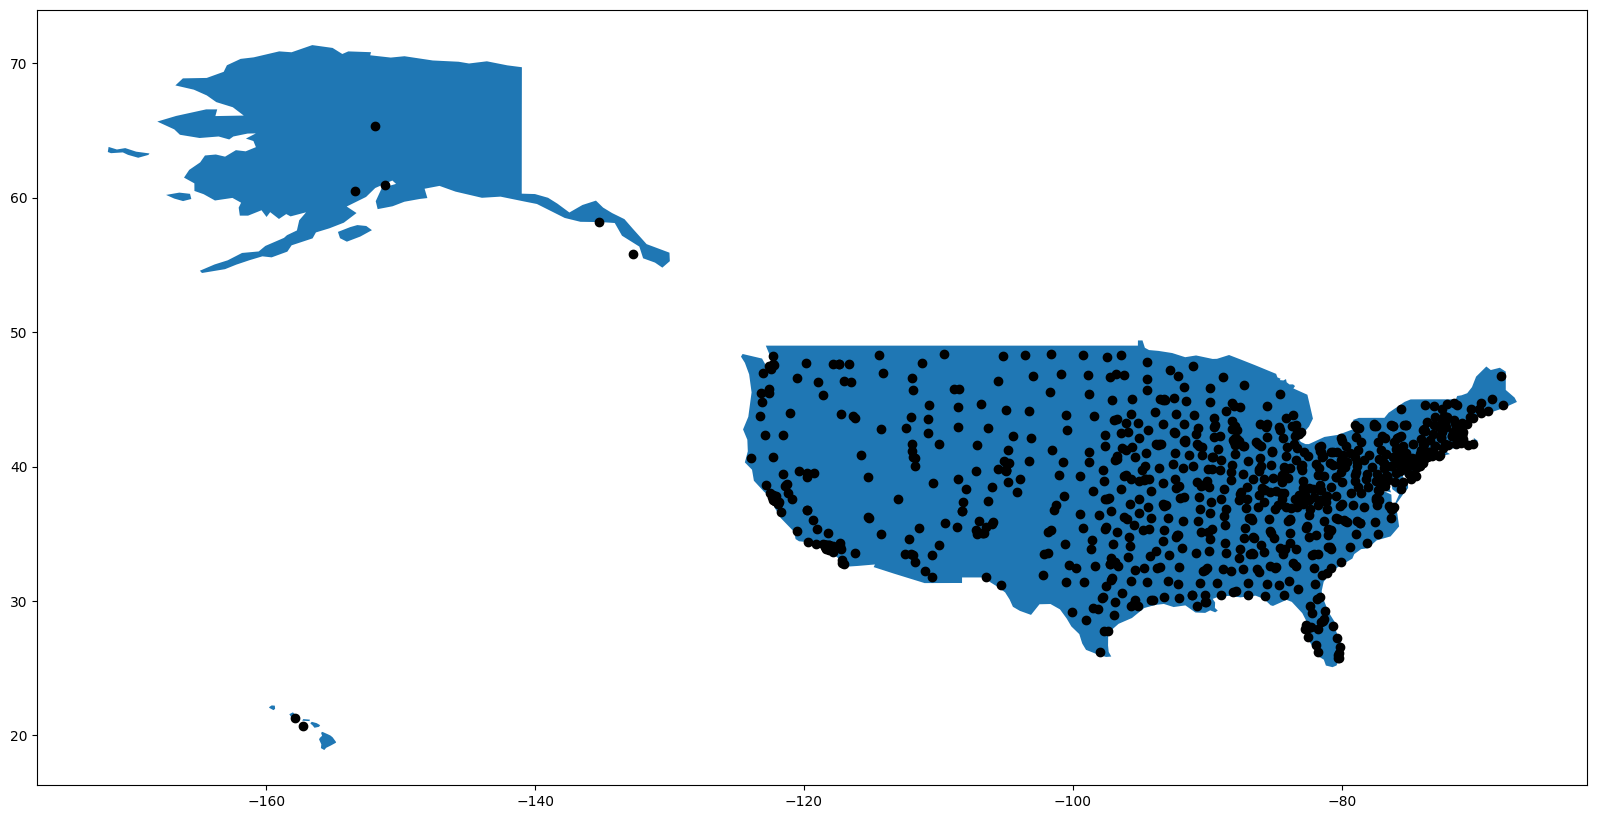

In [6]:
axis = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))
df_coords_to_geo.plot(ax=axis, color = 'black')

In [7]:
zip_coordinates_data.head()

,ZIP3,Lat,Lon
0,10,42.221598,-72.573558
1,11,42.105773,-72.583739
2,12,42.396595,-73.237576
3,13,42.578956,-72.540044
4,14,42.566233,-71.696724


In [8]:
FC_df = zip_coordinates_data.loc[zip_coordinates_data['ZIP3'].isin([303, 134, 799, 841])]
FC_df.head()

,ZIP3,Lat,Lon
113,134,43.104083,-75.332312
279,303,33.822421,-84.342545
728,799,31.765662,-106.448564
766,841,40.739511,-111.889378


In [9]:
c = FC_df.loc[:, ['Lat', 'Lon']]
c.values

array([[  43.10408259,  -75.33231194],
       [  33.82242118,  -84.34254523],
       [  31.7656623 , -106.4485636 ],
       [  40.73951069, -111.8893784 ]])

In [10]:
X = zip_coordinates_data.loc[:, ['Lat', 'Lon']]

In [11]:
id2fc = {id:zip for id, zip in enumerate([134, 303, 799, 841])}
id2fc

{0: 134, 1: 303, 2: 799, 3: 841}

In [12]:
import math
import haversine as hs
from haversine import Unit

def cluster_points(centers, data):
    new_data = pd.DataFrame(data, columns=['Lat', 'Lon'])
    #sorted_points = [[] for _ in range(4)]
    distances = []
    possible_FCs = [[] for _ in range(len(data))]
    for i, x in enumerate(data):
        dists = []
        for c in centers:
            dists.append(hs.haversine(c, x, unit=Unit.MILES))
        for j, d in enumerate(dists):
            if d<1500:
                possible_FCs[i].append(id2fc[j])
        #center_idx = np.argmin(dists)
        #print(dists)
        distances.append(dists)        
        #sorted_points.append(id2fc[center_idx])
    
    new_data['Possible_FCs'] = possible_FCs
    new_data['Distances'] = distances
    return new_data

clustered = cluster_points(c.values, X.values)

In [13]:
clustered

,Lat,Lon,Possible_FCs,Distances
0,42.221598,-72.573558,"[134, 303]","[152.84475432574433, 862.8421869061978, 1988.1..."
1,42.105773,-72.583739,"[134, 303]","[155.86124893391346, 857.4819639393293, 1986.2..."
2,42.396595,-73.237576,"[134, 303]","[116.97783794195817, 844.4320380110271, 1957.0..."
3,42.578956,-72.540044,"[134, 303]","[146.0324239207364, 879.7045337722267, 1994.28..."
4,42.566233,-71.696724,"[134, 303]","[187.89945882816684, 912.7848768692764, 2036.3..."
...,...,...,...,...
887,60.970213,-151.140110,[],"[3234.6798931405724, 3440.523293522389, 2839.4..."
888,60.524385,-153.405946,[],"[3316.534108861567, 3517.0050660922416, 2897.7..."
889,65.359648,-151.894015,[],"[3193.7461414594895, 3478.3367743900535, 2995...."
890,58.188334,-135.227811,[],"[2716.123767788193, 2865.4282278688743, 2269.0..."


So, Atlanta will deliver to 328 loactions; New York to 285 locations; Utah to 191 locations and Texas to 88 locations

In [14]:
df_geo = df_coords_to_geo.merge(clustered, how='left', on=['Lat', 'Lon'])
df_geo.head()

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160),"[134, 303]","[152.84475432574433, 862.8421869061978, 1988.1..."
1,11,42.105773,-72.583739,POINT (-72.58374 42.10577),"[134, 303]","[155.86124893391346, 857.4819639393293, 1986.2..."
2,12,42.396595,-73.237576,POINT (-73.23758 42.39659),"[134, 303]","[116.97783794195817, 844.4320380110271, 1957.0..."
3,13,42.578956,-72.540044,POINT (-72.54004 42.57896),"[134, 303]","[146.0324239207364, 879.7045337722267, 1994.28..."
4,14,42.566233,-71.696724,POINT (-71.69672 42.56623),"[134, 303]","[187.89945882816684, 912.7848768692764, 2036.3..."


In [15]:
FC_points = df_geo[df_geo.ZIP3.isin([134, 303, 799, 841])]
FC_points

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances
115,134,43.104083,-75.332312,POINT (-75.33231 43.10408),"[134, 303]","[0.0, 804.4805759332734, 1864.0958038961369, 1..."
281,303,33.822421,-84.342545,POINT (-84.34255 33.82242),"[134, 303, 799]","[804.4805759332734, 0.0, 1289.291613329621, 15..."
730,799,31.765662,-106.448564,POINT (-106.44856 31.76566),"[303, 799, 841]","[1864.0958038961369, 1289.291613329621, 0.0, 6..."
768,841,40.739511,-111.889378,POINT (-111.88938 40.73951),"[799, 841]","[1871.5431352024623, 1580.4453299309564, 689.8..."


In [16]:
'''c_dict = {134:'green', 303:'red', 799:'purple', 841:'orange'}
axis2 = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))
df_geo.plot(ax = axis2, c = [c_dict[cen] for cen in df_geo['Possible_FCs']])
FC_points.plot(ax=axis2, c='black', marker='*', markersize = 100)'''

"c_dict = {134:'green', 303:'red', 799:'purple', 841:'orange'}\naxis2 = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))\ndf_geo.plot(ax = axis2, c = [c_dict[cen] for cen in df_geo['Possible_FCs']])\nFC_points.plot(ax=axis2, c='black', marker='*', markersize = 100)"

In [17]:
df_geo.head()

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160),"[134, 303]","[152.84475432574433, 862.8421869061978, 1988.1..."
1,11,42.105773,-72.583739,POINT (-72.58374 42.10577),"[134, 303]","[155.86124893391346, 857.4819639393293, 1986.2..."
2,12,42.396595,-73.237576,POINT (-73.23758 42.39659),"[134, 303]","[116.97783794195817, 844.4320380110271, 1957.0..."
3,13,42.578956,-72.540044,POINT (-72.54004 42.57896),"[134, 303]","[146.0324239207364, 879.7045337722267, 1994.28..."
4,14,42.566233,-71.696724,POINT (-71.69672 42.56623),"[134, 303]","[187.89945882816684, 912.7848768692764, 2036.3..."


In [18]:
def lead_time(dists):
    lead_time = None
    if min(dists)<500:
        lead_time = 1
    elif min(dists)>=500 and min(dists)<1000:
        lead_time = 2
    elif min(dists)>=1000 and min(dists)<1500:
        lead_time = 3
    return lead_time

In [19]:
df_geo['LeadTime'] = df_geo['Distances'].apply(lead_time)

In [20]:
df_geo

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances,LeadTime
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160),"[134, 303]","[152.84475432574433, 862.8421869061978, 1988.1...",1.0
1,11,42.105773,-72.583739,POINT (-72.58374 42.10577),"[134, 303]","[155.86124893391346, 857.4819639393293, 1986.2...",1.0
2,12,42.396595,-73.237576,POINT (-73.23758 42.39659),"[134, 303]","[116.97783794195817, 844.4320380110271, 1957.0...",1.0
3,13,42.578956,-72.540044,POINT (-72.54004 42.57896),"[134, 303]","[146.0324239207364, 879.7045337722267, 1994.28...",1.0
4,14,42.566233,-71.696724,POINT (-71.69672 42.56623),"[134, 303]","[187.89945882816684, 912.7848768692764, 2036.3...",1.0
...,...,...,...,...,...,...,...
889,995,60.970213,-151.140110,POINT (-151.14011 60.97021),[],"[3234.6798931405724, 3440.523293522389, 2839.4...",NaN
890,996,60.524385,-153.405946,POINT (-153.40595 60.52438),[],"[3316.534108861567, 3517.0050660922416, 2897.7...",NaN
891,997,65.359648,-151.894015,POINT (-151.89402 65.35965),[],"[3193.7461414594895, 3478.3367743900535, 2995....",NaN
892,998,58.188334,-135.227811,POINT (-135.22781 58.18833),[],"[2716.123767788193, 2865.4282278688743, 2269.0...",NaN


In [21]:
df_geo['Possible_FCs'].value_counts()

Possible_FCs
[134, 303, 799, 841]    340
[134, 303]              272
[799, 841]              122
[134, 303, 799]          93
[303, 799, 841]          59
[]                        6
[134, 303, 841]           1
[841]                     1
Name: count, dtype: int64

In [22]:
np.unique(df_geo['Possible_FCs'])

array([list([]), list([134, 303]), list([134, 303, 799]),
       list([134, 303, 799, 841]), list([134, 303, 841]),
       list([303, 799, 841]), list([799, 841]), list([841])], dtype=object)

In [23]:
df_geos_with_regions = df_geo.copy()
for i in range(len(df_geos_with_regions)):
    for j, fcs in enumerate(np.unique(df_geo['Possible_FCs'])):
        if df_geos_with_regions.loc[i, 'Possible_FCs'] == fcs:
            df_geos_with_regions.loc[i, 'Regions'] = j

In [24]:
df_geos_with_regions['Regions'] = df_geos_with_regions['Regions'].astype('int')

In [25]:
df_geos_with_regions

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances,LeadTime,Regions
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160),"[134, 303]","[152.84475432574433, 862.8421869061978, 1988.1...",1.0,1
1,11,42.105773,-72.583739,POINT (-72.58374 42.10577),"[134, 303]","[155.86124893391346, 857.4819639393293, 1986.2...",1.0,1
2,12,42.396595,-73.237576,POINT (-73.23758 42.39659),"[134, 303]","[116.97783794195817, 844.4320380110271, 1957.0...",1.0,1
3,13,42.578956,-72.540044,POINT (-72.54004 42.57896),"[134, 303]","[146.0324239207364, 879.7045337722267, 1994.28...",1.0,1
4,14,42.566233,-71.696724,POINT (-71.69672 42.56623),"[134, 303]","[187.89945882816684, 912.7848768692764, 2036.3...",1.0,1
...,...,...,...,...,...,...,...,...
889,995,60.970213,-151.140110,POINT (-151.14011 60.97021),[],"[3234.6798931405724, 3440.523293522389, 2839.4...",NaN,0
890,996,60.524385,-153.405946,POINT (-153.40595 60.52438),[],"[3316.534108861567, 3517.0050660922416, 2897.7...",NaN,0
891,997,65.359648,-151.894015,POINT (-151.89402 65.35965),[],"[3193.7461414594895, 3478.3367743900535, 2995....",NaN,0
892,998,58.188334,-135.227811,POINT (-135.22781 58.18833),[],"[2716.123767788193, 2865.4282278688743, 2269.0...",NaN,0


In [26]:
df_geos_with_regions.drop(df_geos_with_regions[df_geos_with_regions['Regions'] == 0].index, inplace=True)
df_geos_with_regions.Regions.value_counts()

Regions
3    340
1    272
6    122
2     93
5     59
4      1
7      1
Name: count, dtype: int64

In [27]:
colors = ['purple', 'black', 'green', 'cyan', 'pink', 'yellow', 'olive']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: >

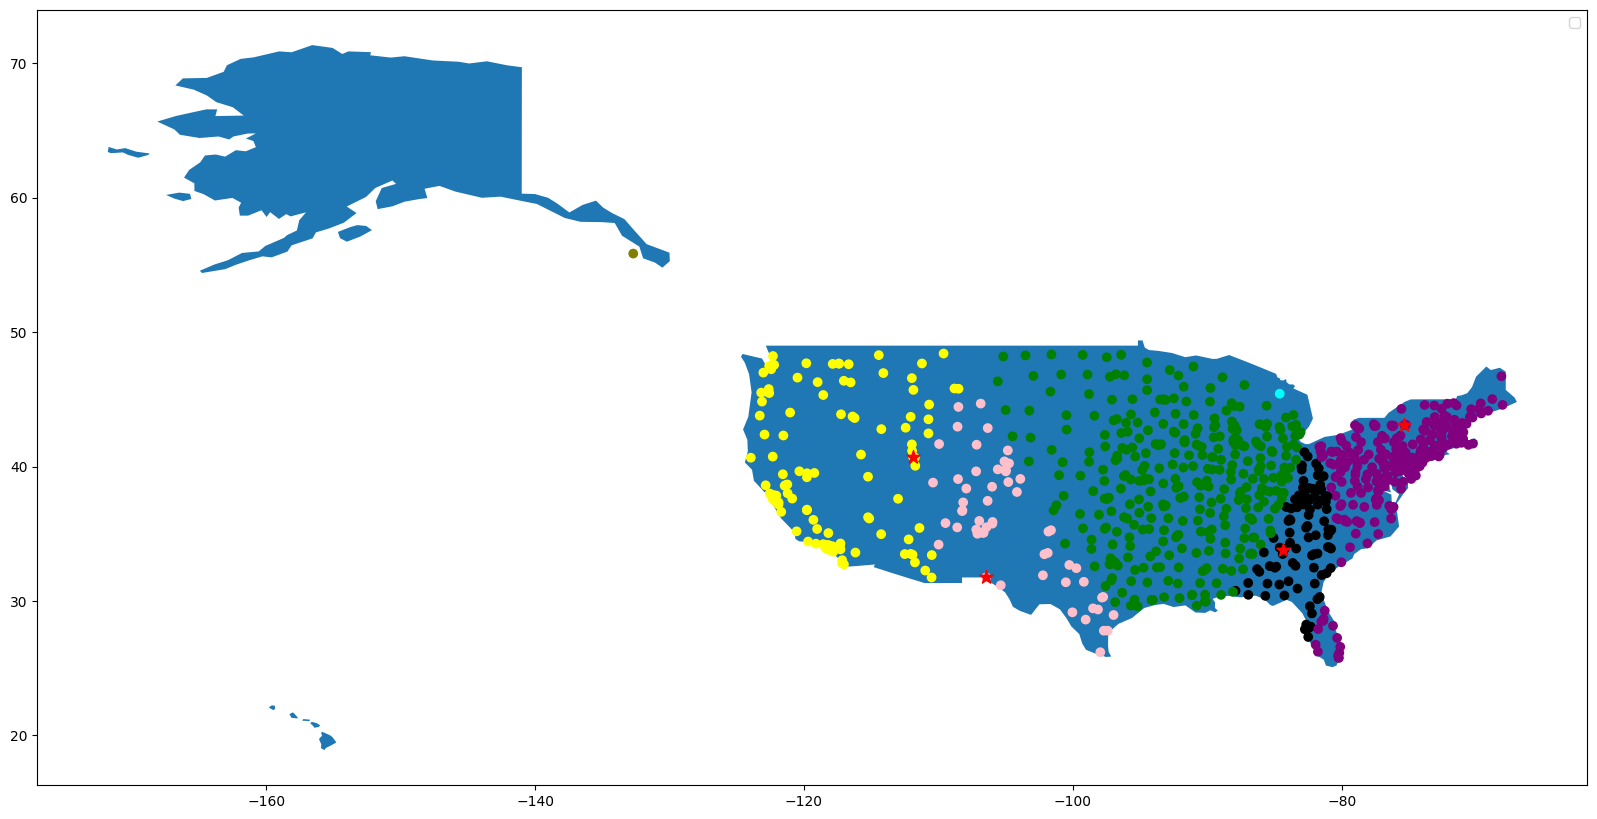

In [28]:
axis3 = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))
df_geos_with_regions.plot(ax = axis3, c = [colors[reg-1] for reg in df_geos_with_regions['Regions']], legend=True)
plt.legend()
FC_points.plot(ax=axis3, c='red', marker='*', markersize = 100)

In [29]:
df_geos_with_regions_exploded = df_geos_with_regions.explode(column='Possible_FCs', ignore_index=True)
df_geos_with_regions_exploded

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances,LeadTime,Regions
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160),134,"[152.84475432574433, 862.8421869061978, 1988.1...",1.0,1
1,10,42.221598,-72.573558,POINT (-72.57356 42.22160),303,"[152.84475432574433, 862.8421869061978, 1988.1...",1.0,1
2,11,42.105773,-72.583739,POINT (-72.58374 42.10577),134,"[155.86124893391346, 857.4819639393293, 1986.2...",1.0,1
3,11,42.105773,-72.583739,POINT (-72.58374 42.10577),303,"[155.86124893391346, 857.4819639393293, 1986.2...",1.0,1
4,12,42.396595,-73.237576,POINT (-73.23758 42.39659),134,"[116.97783794195817, 844.4320380110271, 1957.0...",1.0,1
...,...,...,...,...,...,...,...,...
2603,993,46.284993,-118.983570,POINT (-118.98357 46.28499),799,"[2127.9544816559946, 2003.3573102348687, 1204....",2.0,6
2604,993,46.284993,-118.983570,POINT (-118.98357 46.28499),841,"[2127.9544816559946, 2003.3573102348687, 1204....",2.0,6
2605,994,46.385250,-117.035920,POINT (-117.03592 46.38525),799,"[2035.1861215855918, 1914.9504771216746, 1156....",1.0,6
2606,994,46.385250,-117.035920,POINT (-117.03592 46.38525),841,"[2035.1861215855918, 1914.9504771216746, 1156....",1.0,6


In [30]:
FC_points

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances
115,134,43.104083,-75.332312,POINT (-75.33231 43.10408),"[134, 303]","[0.0, 804.4805759332734, 1864.0958038961369, 1..."
281,303,33.822421,-84.342545,POINT (-84.34255 33.82242),"[134, 303, 799]","[804.4805759332734, 0.0, 1289.291613329621, 15..."
730,799,31.765662,-106.448564,POINT (-106.44856 31.76566),"[303, 799, 841]","[1864.0958038961369, 1289.291613329621, 0.0, 6..."
768,841,40.739511,-111.889378,POINT (-111.88938 40.73951),"[799, 841]","[1871.5431352024623, 1580.4453299309564, 689.8..."


In [31]:
FC_points = FC_points.drop('Possible_FCs', axis = 1)
FC_points

,ZIP3,Lat,Lon,geometry,Distances
115,134,43.104083,-75.332312,POINT (-75.33231 43.10408),"[0.0, 804.4805759332734, 1864.0958038961369, 1..."
281,303,33.822421,-84.342545,POINT (-84.34255 33.82242),"[804.4805759332734, 0.0, 1289.291613329621, 15..."
730,799,31.765662,-106.448564,POINT (-106.44856 31.76566),"[1864.0958038961369, 1289.291613329621, 0.0, 6..."
768,841,40.739511,-111.889378,POINT (-111.88938 40.73951),"[1871.5431352024623, 1580.4453299309564, 689.8..."


In [32]:
from shapely.geometry import LineString
df_lines = pd.merge(FC_points, df_geos_with_regions_exploded, how='cross')
df_lines = df_lines[df_lines['Possible_FCs'] == df_lines['ZIP3_x']]
df_lines = df_lines.reset_index()
df_lines['Distance'] = 0.0

In [33]:
for i in range(len(df_lines)):
    point1 = (df_lines.loc[i, 'Lat_x'], df_lines.loc[i, 'Lon_x'])
    point2 = (df_lines.loc[i, 'Lat_y'], df_lines.loc[i, 'Lon_y'])
    df_lines.loc[i, 'Distance'] = hs.haversine(point1, point2, unit='mi')

In [34]:
df_lines = df_lines[['ZIP3_x', 'geometry_x', 'ZIP3_y', 'geometry_y', 'LeadTime', 'Distance']]
df_lines['Lines'] = df_lines.apply(lambda x: LineString([x['geometry_x'], x['geometry_y']]), axis=1)
df_lines.head()

,ZIP3_x,geometry_x,ZIP3_y,geometry_y,LeadTime,Distance,Lines
0,134,POINT (-75.33231 43.10408),10,POINT (-72.57356 42.22160),1.0,152.844754,"LINESTRING (-75.33231 43.10408, -72.57356 42.2..."
1,134,POINT (-75.33231 43.10408),11,POINT (-72.58374 42.10577),1.0,155.861249,"LINESTRING (-75.33231 43.10408, -72.58374 42.1..."
2,134,POINT (-75.33231 43.10408),12,POINT (-73.23758 42.39659),1.0,116.977838,"LINESTRING (-75.33231 43.10408, -73.23758 42.3..."
3,134,POINT (-75.33231 43.10408),13,POINT (-72.54004 42.57896),1.0,146.032424,"LINESTRING (-75.33231 43.10408, -72.54004 42.5..."
4,134,POINT (-75.33231 43.10408),14,POINT (-71.69672 42.56623),1.0,187.899459,"LINESTRING (-75.33231 43.10408, -71.69672 42.5..."


In [35]:
price_to_ship_in_zip_data

,Zone,Cost ($) per product unit,minimum_distance,maximum_distance
0,1,13.29,0,50
1,2,15.09,50,150
2,3,19.05,150,300
3,4,24.15,300,600
4,5,28.73,600,1000
5,6,34.00,1000,1400
6,7,36.17,1400,1800
7,8,38.81,1800,50000


In [36]:
def get_cost(dist):
    cost = 0.0
    for j in range(len(price_to_ship_in_zip_data)):
        if dist > price_to_ship_in_zip_data.loc[j, 'minimum_distance'] and dist <= price_to_ship_in_zip_data.loc[j, 'maximum_distance']:
            cost = price_to_ship_in_zip_data.loc[j, 'Cost ($) per product unit']
            break
    return cost

In [37]:
df_lines['Cost'] = df_lines['Distance'].apply(get_cost)
df_lines

,ZIP3_x,geometry_x,ZIP3_y,geometry_y,LeadTime,Distance,Lines,Cost
0,134,POINT (-75.33231 43.10408),10,POINT (-72.57356 42.22160),1.0,152.844754,"LINESTRING (-75.33231 43.10408, -72.57356 42.2...",19.05
1,134,POINT (-75.33231 43.10408),11,POINT (-72.58374 42.10577),1.0,155.861249,"LINESTRING (-75.33231 43.10408, -72.58374 42.1...",19.05
2,134,POINT (-75.33231 43.10408),12,POINT (-73.23758 42.39659),1.0,116.977838,"LINESTRING (-75.33231 43.10408, -73.23758 42.3...",15.09
3,134,POINT (-75.33231 43.10408),13,POINT (-72.54004 42.57896),1.0,146.032424,"LINESTRING (-75.33231 43.10408, -72.54004 42.5...",15.09
4,134,POINT (-75.33231 43.10408),14,POINT (-71.69672 42.56623),1.0,187.899459,"LINESTRING (-75.33231 43.10408, -71.69672 42.5...",19.05
...,...,...,...,...,...,...,...,...
2603,841,POINT (-111.88938 40.73951),991,POINT (-117.86336 47.64105),2.0,560.834467,"LINESTRING (-111.88938 40.73951, -117.86336 47...",24.15
2604,841,POINT (-111.88938 40.73951),992,POINT (-117.39643 47.66157),2.0,550.250928,"LINESTRING (-111.88938 40.73951, -117.39643 47...",24.15
2605,841,POINT (-111.88938 40.73951),993,POINT (-118.98357 46.28499),2.0,522.237282,"LINESTRING (-111.88938 40.73951, -118.98357 46...",24.15
2606,841,POINT (-111.88938 40.73951),994,POINT (-117.03592 46.38525),1.0,467.267063,"LINESTRING (-111.88938 40.73951, -117.03592 46...",24.15


In [38]:
df_lines.Cost.mean()

28.119888803680983

In [39]:
df_lines = df_lines.set_geometry('Lines')
df_lines['LeadTime'] = df_lines['LeadTime'].apply(int)

In [40]:
ltc = {1: 'green', 2: 'yellow', 3: 'orange'}

<Axes: >

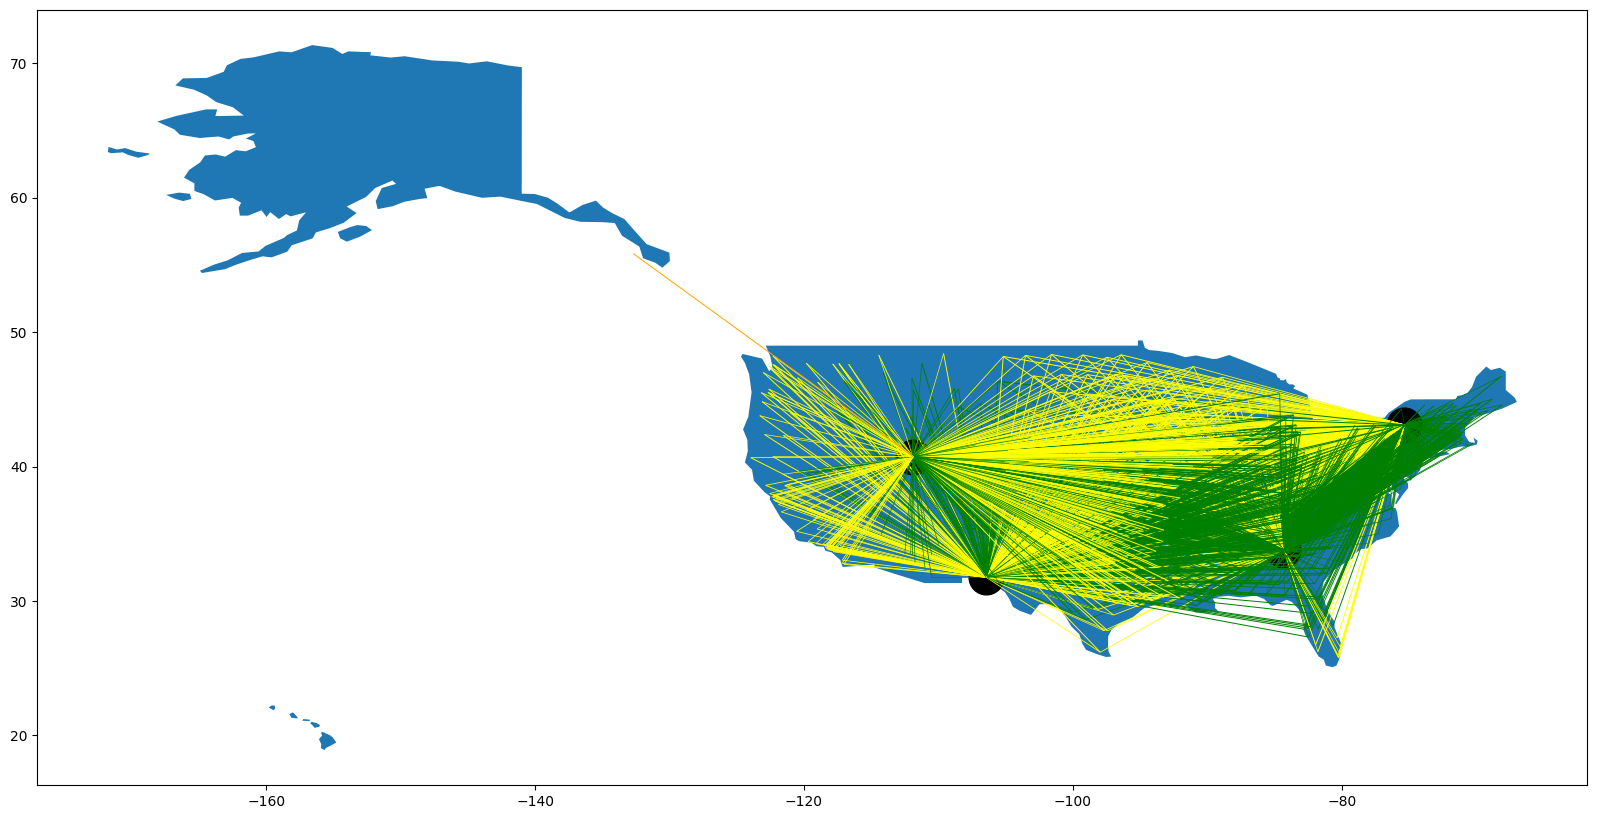

In [41]:
axis4 = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))
df_lines.plot(ax = axis4, color=[ltc[lt] for lt in df_lines['LeadTime']], linewidth=df_lines['Cost']/50)
FC_points.plot(ax=axis4, c='black', marker='.', markersize =2500)

In [42]:
demand_seasonality_data.head()

,Week of Year,Proportion,Unnamed: 2,Day of Week,Proportion.1
0,1,1.00%,NaN,1.0,10%
1,2,1.00%,NaN,2.0,15%
2,3,1.25%,NaN,3.0,20%
3,4,1.25%,NaN,4.0,20%
4,5,1.00%,NaN,5.0,15%


In [43]:
demand_seasonality_data.rename(columns={'Proportion': 'Proportion_by_week', 'Proportion.1': 'Proportion_by_day'}, inplace=True)

In [44]:
demand_seasonality_data['Proportion_by_day'] = demand_seasonality_data['Proportion_by_day'].str.replace('%', '')
demand_seasonality_data['Proportion_by_week'] = demand_seasonality_data['Proportion_by_week'].str.replace('%', '')

In [45]:
demand_seasonality_data.head()

,Week of Year,Proportion_by_week,Unnamed: 2,Day of Week,Proportion_by_day
0,1,1.00,NaN,1.0,10
1,2,1.00,NaN,2.0,15
2,3,1.25,NaN,3.0,20
3,4,1.25,NaN,4.0,20
4,5,1.00,NaN,5.0,15


In [46]:
demand_seasonality_data.drop('Unnamed: 2', axis=1, inplace=True)

In [47]:
demand_seasonality_data.head()

,Week of Year,Proportion_by_week,Day of Week,Proportion_by_day
0,1,1.00,1.0,10
1,2,1.00,2.0,15
2,3,1.25,3.0,20
3,4,1.25,4.0,20
4,5,1.00,5.0,15


In [48]:
demand_seasonality_data['Proportion_by_day'] = demand_seasonality_data['Proportion_by_day'].astype(float)
demand_seasonality_data['Proportion_by_week'] = demand_seasonality_data['Proportion_by_week'].astype(float)

demand_seasonality_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week of Year        52 non-null     int64  
 1   Proportion_by_week  52 non-null     float64
 2   Day of Week         7 non-null      float64
 3   Proportion_by_day   7 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 1.8 KB


In [49]:
demand_seasonality_data['Proportion_by_day'].sum()

100.0

In [50]:
demand_seasonality_data.head()

,Week of Year,Proportion_by_week,Day of Week,Proportion_by_day
0,1,1.00,1.0,10.0
1,2,1.00,2.0,15.0
2,3,1.25,3.0,20.0
3,4,1.25,4.0,20.0
4,5,1.00,5.0,15.0


In [51]:
demand_seasonality_data_day = demand_seasonality_data[['Day of Week', 'Proportion_by_day']]
demand_seasonality_data_week = demand_seasonality_data[['Week of Year', 'Proportion_by_week']]

In [52]:
demand_seasonality_data_day = demand_seasonality_data_day.dropna()

In [53]:
demand_seasonality_data_day

,Day of Week,Proportion_by_day
0,1.0,10.0
1,2.0,15.0
2,3.0,20.0
3,4.0,20.0
4,5.0,15.0
5,6.0,15.0
6,7.0,5.0


In [54]:
demand_seasonality_data_week.head()

,Week of Year,Proportion_by_week
0,1,1.00
1,2,1.00
2,3,1.25
3,4,1.25
4,5,1.00


In [55]:
Cv_day = 0.2
demand_seasonality_data_day['sigma_day'] = Cv_day * demand_seasonality_data_day['Proportion_by_day']
np.random.seed(42)
for i in range(len(demand_seasonality_data_day)):
    demand_seasonality_data_day.loc[i, 'factor_day'] = np.random.normal(demand_seasonality_data_day.loc[i, 'Proportion_by_day'], demand_seasonality_data_day.loc[i, 'sigma_day'], 1)

demand_seasonality_data_day

,Day of Week,Proportion_by_day,sigma_day,factor_day
0,1.0,10.0,2.0,10.993428
1,2.0,15.0,3.0,14.585207
2,3.0,20.0,4.0,22.590754
3,4.0,20.0,4.0,26.092119
4,5.0,15.0,3.0,14.297540
5,6.0,15.0,3.0,14.297589
6,7.0,5.0,1.0,6.579213


In [56]:
Cv_week = 0.15
demand_seasonality_data_week['sigma_week'] = Cv_week * demand_seasonality_data_week['Proportion_by_week']
np.random.seed(42)
for i in range(len(demand_seasonality_data_week)):
    demand_seasonality_data_week.loc[i, 'factor_week'] = np.random.normal(demand_seasonality_data_week.loc[i, 'Proportion_by_week'], demand_seasonality_data_week.loc[i, 'sigma_week'], 1)

demand_seasonality_data_week.head()

C:\Users\Arnav Ketkar\AppData\Local\Temp\ipykernel_109248\122555294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_seasonality_data_week['sigma_week'] = Cv_week * demand_seasonality_data_week['Proportion_by_week']


,Week of Year,Proportion_by_week,sigma_week,factor_week
0,1,1.00,0.1500,1.074507
1,2,1.00,0.1500,0.979260
2,3,1.25,0.1875,1.371442
3,4,1.25,0.1875,1.535568
4,5,1.00,0.1500,0.964877


In [57]:
worst_case_yearly_growth = 1.8*1.15*1.04*0.01
best_case_yearly_growth = 1.8*1.25*1.12*0.01
median_case_yearly_growth = 1.8*1.20*1.075*0.01

In [58]:
def find_weekly_factors(row):
    return pd.Series({'worst_case_weekly_growth': worst_case_yearly_growth * row['factor_week']/100,
                        'best_case_weekly_growth': best_case_yearly_growth * row['factor_week']/100,
                        'median_case_weekly_growth': median_case_yearly_growth * row['factor_week']/100})

demand_seasonality_data_week[['worst_case_weekly_growth', 'best_case_weekly_growth', 'median_case_weekly_growth']] = demand_seasonality_data_week.apply(lambda row: find_weekly_factors(row), axis=1)

In [59]:
demand_seasonality_data_week.head()

,Week of Year,Proportion_by_week,sigma_week,factor_week,worst_case_weekly_growth,best_case_weekly_growth,median_case_weekly_growth
0,1,1.00,0.1500,1.074507,0.000231,0.000271,0.000250
1,2,1.00,0.1500,0.979260,0.000211,0.000247,0.000227
2,3,1.25,0.1875,1.371442,0.000295,0.000346,0.000318
3,4,1.25,0.1875,1.535568,0.000331,0.000387,0.000357
4,5,1.00,0.1500,0.964877,0.000208,0.000243,0.000224


In [60]:
def find_daily_factors(row):
    return pd.Series({'worst_case_daily_growth': worst_case_yearly_growth * row['factor_day']/100,
                        'best_case_daily_growth': best_case_yearly_growth * row['factor_day']/100,
                        'median_case_daily_growth': median_case_yearly_growth * row['factor_day']/100})

demand_seasonality_data_day[['worst_case_daily_growth', 'best_case_daily_growth', 'median_case_daily_growth']] = demand_seasonality_data_day.apply(lambda row: find_daily_factors(row), axis=1)

In [61]:
demand_seasonality_data_day

,Day of Week,Proportion_by_day,sigma_day,factor_day,worst_case_daily_growth,best_case_daily_growth,median_case_daily_growth
0,1.0,10.0,2.0,10.993428,0.002367,0.002770,0.002553
1,2.0,15.0,3.0,14.585207,0.003140,0.003675,0.003387
2,3.0,20.0,4.0,22.590754,0.004863,0.005693,0.005246
3,4.0,20.0,4.0,26.092119,0.005617,0.006575,0.006059
4,5.0,15.0,3.0,14.297540,0.003078,0.003603,0.003320
5,6.0,15.0,3.0,14.297589,0.003078,0.003603,0.003320
6,7.0,5.0,1.0,6.579213,0.001416,0.001658,0.001528


In [62]:
factor_df = pd.DataFrame(columns=['Weekly_Factor %', 'Daily_Factor %', 'Overall_Factor'])
weekly_facs = [factor for factor in demand_seasonality_data_week['factor_week'].values for _ in range(7)]
factor_df['Weekly_Factor %'] = weekly_facs
factor_df['Daily_Factor %'] = list(demand_seasonality_data_day['factor_day'].values) * 52
factor_df['Overall_Factor'] = factor_df['Weekly_Factor %'] * factor_df['Daily_Factor %']

factor_df

,Weekly_Factor %,Daily_Factor %,Overall_Factor
0,1.074507,10.993428,11.812517
1,1.074507,14.585207,15.671909
2,1.074507,22.590754,24.273926
3,1.074507,26.092119,28.036168
4,1.074507,14.297540,15.362808
...,...,...,...
359,0.942238,22.590754,21.285859
360,0.942238,26.092119,24.584977
361,0.942238,14.297540,13.471680
362,0.942238,14.297589,13.471727


In [63]:
factor_df['Overall_Factor'].sum()/10**4

1.050678039204183

the weekly, daily, and overall factors are all products of 2 percentages

In [64]:
def normalize_col(col):
    normalized_col = col/col.sum()
    return normalized_col

factor_df['Normalized_Overall_Factor'] = normalize_col(factor_df['Overall_Factor'])
factor_df

,Weekly_Factor %,Daily_Factor %,Overall_Factor,Normalized_Overall_Factor
0,1.074507,10.993428,11.812517,0.001124
1,1.074507,14.585207,15.671909,0.001492
2,1.074507,22.590754,24.273926,0.002310
3,1.074507,26.092119,28.036168,0.002668
4,1.074507,14.297540,15.362808,0.001462
...,...,...,...,...
359,0.942238,22.590754,21.285859,0.002026
360,0.942238,26.092119,24.584977,0.002340
361,0.942238,14.297540,13.471680,0.001282
362,0.942238,14.297589,13.471727,0.001282


In [65]:
(factor_df['Normalized_Overall_Factor']*2e6*median_case_yearly_growth)

0       52.211360
1       69.269883
2      107.290825
3      123.919945
4       67.903658
          ...    
359     94.083560
360    108.665672
361     59.544867
362     59.545072
363     27.400403
Name: Normalized_Overall_Factor, Length: 364, dtype: float64

In [66]:
(factor_df['Normalized_Overall_Factor']*2e6*median_case_yearly_growth).sum()

46440.0

In [67]:
(factor_df['Normalized_Overall_Factor']*2e6*median_case_yearly_growth).var()

12488.859902122173

In [68]:
USA_territory_table = pd.DataFrame(columns=['Dollars', 'Units', 'Volume', 'Weight'], index=['Yearly', 'Weekly', 'Daily'])


In [69]:
demand_pmf_by_zip_data

,ZIP3,PMF
0,10,0.002022
1,11,0.001160
2,12,0.000565
3,13,0.000148
4,14,0.000743
...,...,...
847,989,0.001130
848,990,0.000327
849,992,0.001040
850,993,0.000951


In [70]:
Cv_pmf = 0.15
demand_pmf_by_zip_data['sigma_pmf'] = Cv_pmf * demand_pmf_by_zip_data['PMF']
np.random.seed(42)
for i in range(len(demand_pmf_by_zip_data)):
    demand_pmf_by_zip_data.loc[i, 'pmf_updated'] = np.random.normal(demand_pmf_by_zip_data.loc[i, 'PMF'], demand_pmf_by_zip_data.loc[i, 'sigma_pmf'], 1)

demand_pmf_by_zip_data

,ZIP3,PMF,sigma_pmf,pmf_updated
0,10,0.002022,0.000303,0.002172
1,11,0.001160,0.000174,0.001136
2,12,0.000565,0.000085,0.000620
3,13,0.000148,0.000022,0.000182
4,14,0.000743,0.000111,0.000717
...,...,...,...,...
847,989,0.001130,0.000169,0.001546
848,990,0.000327,0.000049,0.000296
849,992,0.001040,0.000156,0.000958
850,993,0.000951,0.000143,0.000862


In [71]:
for i in range(len(demand_pmf_by_zip_data)):
    demand_pmf_by_zip_data.loc[i, 'market_share_units_yearly'] = np.ceil(demand_pmf_by_zip_data.loc[i, 'pmf_updated'] * 2e6 * median_case_yearly_growth)
    
demand_pmf_by_zip_data

,ZIP3,PMF,sigma_pmf,pmf_updated,market_share_units_yearly
0,10,0.002022,0.000303,0.002172,101.0
1,11,0.001160,0.000174,0.001136,53.0
2,12,0.000565,0.000085,0.000620,29.0
3,13,0.000148,0.000022,0.000182,9.0
4,14,0.000743,0.000111,0.000717,34.0
...,...,...,...,...,...
847,989,0.001130,0.000169,0.001546,72.0
848,990,0.000327,0.000049,0.000296,14.0
849,992,0.001040,0.000156,0.000958,45.0
850,993,0.000951,0.000143,0.000862,41.0


In [72]:
zip3_state = pd.read_json('threeDigitZipCodes.json').T[['id', 'state']]

In [73]:
zip3_state['id'] = zip3_state['id'].astype(int)

In [74]:
demand_data = pd.merge(demand_pmf_by_zip_data, zip3_state, how='left', left_on='ZIP3', right_on='id')
demand_data.drop('id', axis=1, inplace=True)
demand_data

,ZIP3,PMF,sigma_pmf,pmf_updated,market_share_units_yearly,state
0,10,0.002022,0.000303,0.002172,101.0,MA
1,11,0.001160,0.000174,0.001136,53.0,MA
2,12,0.000565,0.000085,0.000620,29.0,MA
3,13,0.000148,0.000022,0.000182,9.0,MA
4,14,0.000743,0.000111,0.000717,34.0,MA
...,...,...,...,...,...,...
847,989,0.001130,0.000169,0.001546,72.0,WA
848,990,0.000327,0.000049,0.000296,14.0,WA
849,992,0.001040,0.000156,0.000958,45.0,WA
850,993,0.000951,0.000143,0.000862,41.0,WA


In [75]:
demand_data_by_state =  demand_data.groupby('state')['market_share_units_yearly'].sum()
demand_data_by_state = pd.DataFrame(demand_data_by_state)
demand_data_by_state.head()

,market_share_units_yearly
state,
AL,427.0
AR,313.0
AZ,1390.0
CA,5743.0
CO,2126.0


In [76]:
import geopandas as gpd
states = gpd.read_file('States_shapefile.shp')
states = states[~states['State_Code'].isin(['AK', 'HI'])]
states_data_merged = pd.merge(states, demand_data_by_state, how='left', left_on='State_Code', right_on='state')
states_data_merged.head()

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,market_share_units_yearly
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",427.0
1,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",1390.0
2,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",313.0
3,5,NaN,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",5743.0
4,6,ECOMAP,CO,COLORADO,F,924,"POLYGON ((-102.04446 37.64147, -102.04201 37.3...",2126.0


c:\Users\Arnav Ketkar\anaconda3\envs\Casework-1\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Text(0.5, 1.0, 'Yearly Demand by State')

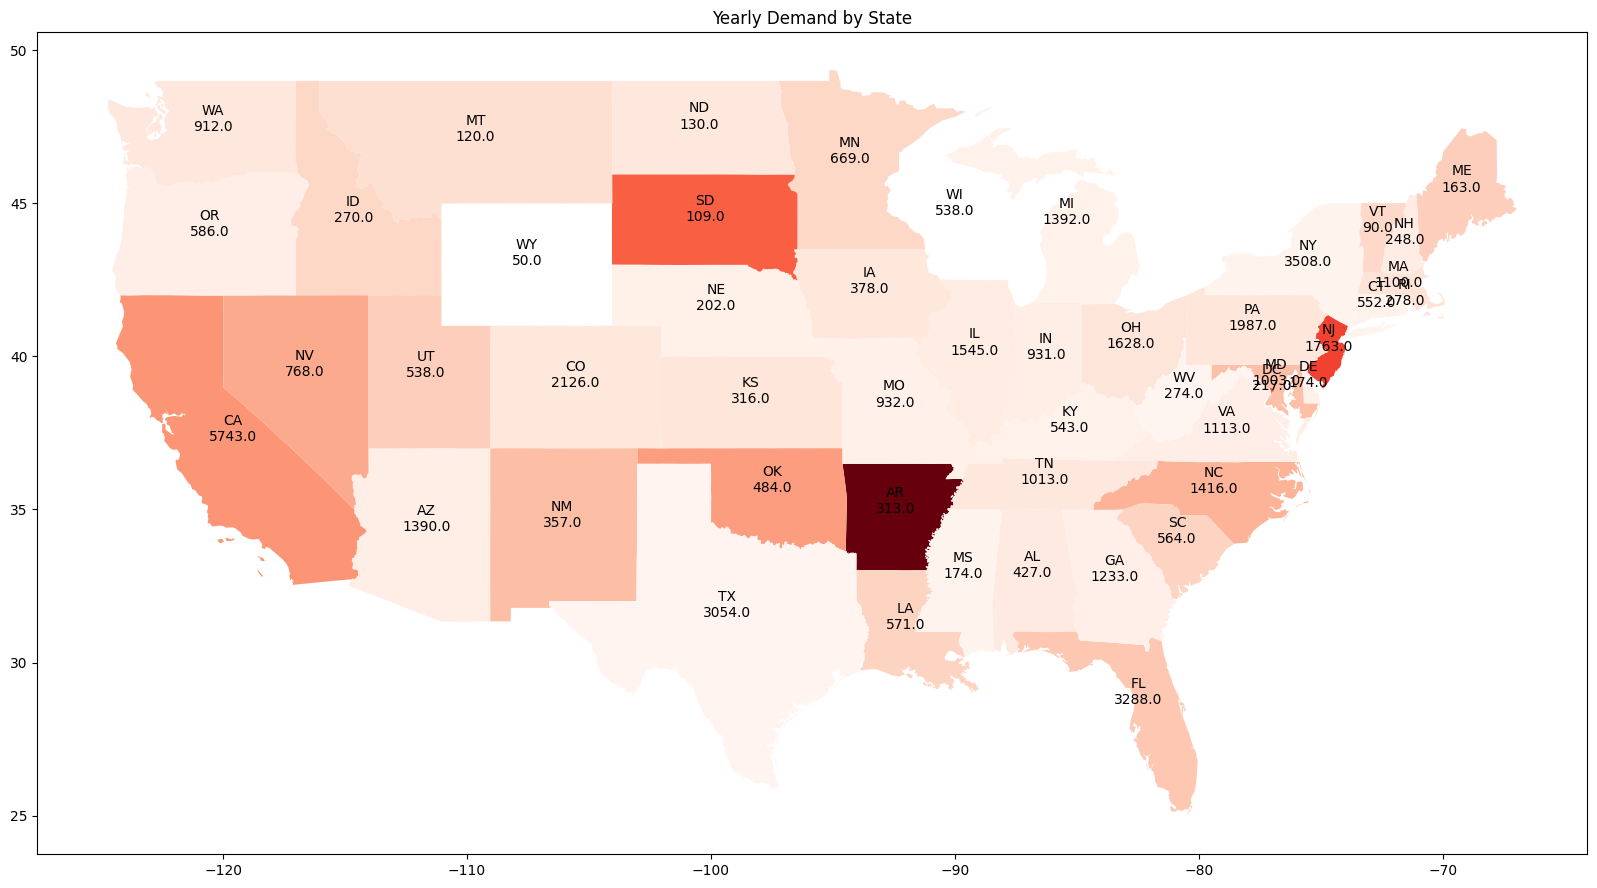

In [77]:
ax5 = states.plot(column=states_data_merged['market_share_units_yearly'], figsize=(20,20), legend=False, cmap='Reds')
states_data_merged.apply(lambda x: ax5.annotate(text=x.State_Code + '\n' + str(round(x.market_share_units_yearly, 0)), 
                                                xy=x.geometry.centroid.coords[0], ha='center', fontsize=10, color = 'black'),axis=1)
ax5.set_title('Yearly Demand by State')

In [78]:
demand_data_by_state['Price'] = demand_data_by_state['market_share_units_yearly']*300
demand_data_by_state['Weight'] = demand_data_by_state['market_share_units_yearly']*60
demand_data_by_state['Volume'] = demand_data_by_state['market_share_units_yearly']*1.5*2*2

demand_data_by_state.head(10)

,market_share_units_yearly,Price,Weight,Volume
state,,,,
AL,427.0,128100.0,25620.0,2562.0
AR,313.0,93900.0,18780.0,1878.0
AZ,1390.0,417000.0,83400.0,8340.0
CA,5743.0,1722900.0,344580.0,34458.0
CO,2126.0,637800.0,127560.0,12756.0
CT,552.0,165600.0,33120.0,3312.0
DC,217.0,65100.0,13020.0,1302.0
DE,174.0,52200.0,10440.0,1044.0
FL,3288.0,986400.0,197280.0,19728.0


In [79]:
demand_data.head()

,ZIP3,PMF,sigma_pmf,pmf_updated,market_share_units_yearly,state
0,10,0.002022,0.000303,0.002172,101.0,MA
1,11,0.001160,0.000174,0.001136,53.0,MA
2,12,0.000565,0.000085,0.000620,29.0,MA
3,13,0.000148,0.000022,0.000182,9.0,MA
4,14,0.000743,0.000111,0.000717,34.0,MA


In [80]:
df_geo.head()

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances,LeadTime
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160),"[134, 303]","[152.84475432574433, 862.8421869061978, 1988.1...",1.0
1,11,42.105773,-72.583739,POINT (-72.58374 42.10577),"[134, 303]","[155.86124893391346, 857.4819639393293, 1986.2...",1.0
2,12,42.396595,-73.237576,POINT (-73.23758 42.39659),"[134, 303]","[116.97783794195817, 844.4320380110271, 1957.0...",1.0
3,13,42.578956,-72.540044,POINT (-72.54004 42.57896),"[134, 303]","[146.0324239207364, 879.7045337722267, 1994.28...",1.0
4,14,42.566233,-71.696724,POINT (-71.69672 42.56623),"[134, 303]","[187.89945882816684, 912.7848768692764, 2036.3...",1.0


In [81]:
demand_data_updated = pd.merge(demand_data, df_geo, how='left', left_on='ZIP3', right_on='ZIP3')
demand_data_updated.drop(['geometry', 'Distances', 'sigma_pmf'], axis=1, inplace=True)
demand_data_updated

,ZIP3,PMF,pmf_updated,market_share_units_yearly,state,Lat,Lon,Possible_FCs,LeadTime
0,10,0.002022,0.002172,101.0,MA,42.221598,-72.573558,"[134, 303]",1.0
1,11,0.001160,0.001136,53.0,MA,42.105773,-72.583739,"[134, 303]",1.0
2,12,0.000565,0.000620,29.0,MA,42.396595,-73.237576,"[134, 303]",1.0
3,13,0.000148,0.000182,9.0,MA,42.578956,-72.540044,"[134, 303]",1.0
4,14,0.000743,0.000717,34.0,MA,42.566233,-71.696724,"[134, 303]",1.0
...,...,...,...,...,...,...,...,...,...
849,989,0.001130,0.001546,72.0,WA,46.620679,-120.482577,"[799, 841]",2.0
850,990,0.000327,0.000296,14.0,WA,47.667250,-117.399207,"[799, 841]",2.0
851,992,0.001040,0.000958,45.0,WA,47.661571,-117.396431,"[799, 841]",2.0
852,993,0.000951,0.000862,41.0,WA,46.284993,-118.983570,"[799, 841]",2.0


In [82]:
demand_data_updated['Market_Type'] = 'Primary'
demand_data_updated

,ZIP3,PMF,pmf_updated,market_share_units_yearly,state,Lat,Lon,Possible_FCs,LeadTime,Market_Type
0,10,0.002022,0.002172,101.0,MA,42.221598,-72.573558,"[134, 303]",1.0,Primary
1,11,0.001160,0.001136,53.0,MA,42.105773,-72.583739,"[134, 303]",1.0,Primary
2,12,0.000565,0.000620,29.0,MA,42.396595,-73.237576,"[134, 303]",1.0,Primary
3,13,0.000148,0.000182,9.0,MA,42.578956,-72.540044,"[134, 303]",1.0,Primary
4,14,0.000743,0.000717,34.0,MA,42.566233,-71.696724,"[134, 303]",1.0,Primary
...,...,...,...,...,...,...,...,...,...,...
849,989,0.001130,0.001546,72.0,WA,46.620679,-120.482577,"[799, 841]",2.0,Primary
850,990,0.000327,0.000296,14.0,WA,47.667250,-117.399207,"[799, 841]",2.0,Primary
851,992,0.001040,0.000958,45.0,WA,47.661571,-117.396431,"[799, 841]",2.0,Primary
852,993,0.000951,0.000862,41.0,WA,46.284993,-118.983570,"[799, 841]",2.0,Primary


In [83]:
for i in range(len(demand_data_updated)):
    if demand_data_updated.loc[i, 'LeadTime'] == 2.0:
        demand_data_updated.loc[i, 'market_share_units_yearly'] *= 0.9
    elif demand_data_updated.loc[i, 'LeadTime'] == 3.0:
        demand_data_updated.loc[i, 'market_share_units_yearly'] *= 0.75
    else:
        demand_data_updated.loc[i, 'market_share_units_yearly'] *= 1.0
        
demand_data_updated['market_share_units_daily'] = demand_data_updated['market_share_units_yearly']/364
demand_data_updated

,ZIP3,PMF,pmf_updated,market_share_units_yearly,state,Lat,Lon,Possible_FCs,LeadTime,Market_Type,market_share_units_daily
0,10,0.002022,0.002172,101.0,MA,42.221598,-72.573558,"[134, 303]",1.0,Primary,0.277473
1,11,0.001160,0.001136,53.0,MA,42.105773,-72.583739,"[134, 303]",1.0,Primary,0.145604
2,12,0.000565,0.000620,29.0,MA,42.396595,-73.237576,"[134, 303]",1.0,Primary,0.079670
3,13,0.000148,0.000182,9.0,MA,42.578956,-72.540044,"[134, 303]",1.0,Primary,0.024725
4,14,0.000743,0.000717,34.0,MA,42.566233,-71.696724,"[134, 303]",1.0,Primary,0.093407
...,...,...,...,...,...,...,...,...,...,...,...
849,989,0.001130,0.001546,64.8,WA,46.620679,-120.482577,"[799, 841]",2.0,Primary,0.178022
850,990,0.000327,0.000296,12.6,WA,47.667250,-117.399207,"[799, 841]",2.0,Primary,0.034615
851,992,0.001040,0.000958,40.5,WA,47.661571,-117.396431,"[799, 841]",2.0,Primary,0.111264
852,993,0.000951,0.000862,36.9,WA,46.284993,-118.983570,"[799, 841]",2.0,Primary,0.101374


In [84]:
demand_data_updated['market_share_units_yearly'] = np.ceil(demand_data_updated['market_share_units_yearly'])
demand_data_updated

,ZIP3,PMF,pmf_updated,market_share_units_yearly,state,Lat,Lon,Possible_FCs,LeadTime,Market_Type,market_share_units_daily
0,10,0.002022,0.002172,101.0,MA,42.221598,-72.573558,"[134, 303]",1.0,Primary,0.277473
1,11,0.001160,0.001136,53.0,MA,42.105773,-72.583739,"[134, 303]",1.0,Primary,0.145604
2,12,0.000565,0.000620,29.0,MA,42.396595,-73.237576,"[134, 303]",1.0,Primary,0.079670
3,13,0.000148,0.000182,9.0,MA,42.578956,-72.540044,"[134, 303]",1.0,Primary,0.024725
4,14,0.000743,0.000717,34.0,MA,42.566233,-71.696724,"[134, 303]",1.0,Primary,0.093407
...,...,...,...,...,...,...,...,...,...,...,...
849,989,0.001130,0.001546,65.0,WA,46.620679,-120.482577,"[799, 841]",2.0,Primary,0.178022
850,990,0.000327,0.000296,13.0,WA,47.667250,-117.399207,"[799, 841]",2.0,Primary,0.034615
851,992,0.001040,0.000958,41.0,WA,47.661571,-117.396431,"[799, 841]",2.0,Primary,0.111264
852,993,0.000951,0.000862,37.0,WA,46.284993,-118.983570,"[799, 841]",2.0,Primary,0.101374


Task 5

In [85]:
daily_demand = factor_df['Normalized_Overall_Factor']*2e6*median_case_yearly_growth
daily_demand

0       52.211360
1       69.269883
2      107.290825
3      123.919945
4       67.903658
          ...    
359     94.083560
360    108.665672
361     59.544867
362     59.545072
363     27.400403
Name: Normalized_Overall_Factor, Length: 364, dtype: float64

In [86]:
daily_demand_df = pd.DataFrame(columns=['Units', 'Dollars', 'Weight', 'Volume'])
daily_demand_df['Units'] = daily_demand
daily_demand_df['Dollars'] = daily_demand_df['Units'] * 300
daily_demand_df['Weight'] = daily_demand_df['Units'] * 60
daily_demand_df['Volume'] = daily_demand_df['Units'] * 1.5 * 2 * 2
daily_demand_df

,Units,Dollars,Weight,Volume
0,52.211360,15663.407913,3132.681583,313.268158
1,69.269883,20780.964944,4156.192989,415.619299
2,107.290825,32187.247462,6437.449492,643.744949
3,123.919945,37175.983551,7435.196710,743.519671
4,67.903658,20371.097440,4074.219488,407.421949
...,...,...,...,...
359,94.083560,28225.068049,5645.013610,564.501361
360,108.665672,32599.701690,6519.940338,651.994034
361,59.544867,17863.460122,3572.692024,357.269202
362,59.545072,17863.521659,3572.704332,357.270433


In [87]:
daily_demand_df['Units'].sum()

46440.0

In [88]:
clusters2 = zip_coordinates_data.loc[zip_coordinates_data['ZIP3'].isin([134, 303, 799, 841])]
clusters2 = clusters2.loc[:,['Lat', 'Lon']]

coordinate_data = zip_coordinates_data.loc[:, ['Lat', 'Lon']]


id2fc = {id:zip for id,zip in enumerate([134, 303, 799, 841])}


def cluster_points(centroids, data):
    clusters2 = np.array(centroids)
    coordinate_data = np.array(data)
    new_data = pd.DataFrame(coordinate_data, columns=['Lat', 'Lon'])
    sorted_points = []
    distances = []
    for x in coordinate_data:
        dists = []
        for centroid in clusters2:
            dists.append(hs.haversine(centroid, x, unit= Unit.MILES))
        centroid_idx = np.argmin(dists)

        sorted_points.append(id2fc[centroid_idx])
        distances.append(dists[centroid_idx])
    
    new_data['centroid'] = sorted_points
    new_data['Distance'] = distances

    return new_data

clustered2 = cluster_points(clusters2, coordinate_data)

In [89]:
clustered2

,Lat,Lon,centroid,Distance
0,42.221598,-72.573558,134,152.844754
1,42.105773,-72.583739,134,155.861249
2,42.396595,-73.237576,134,116.977838
3,42.578956,-72.540044,134,146.032424
4,42.566233,-71.696724,134,187.899459
...,...,...,...,...
887,60.970213,-151.140110,841,2155.791513
888,60.524385,-153.405946,841,2216.540926
889,65.359648,-151.894015,841,2305.416818
890,58.188334,-135.227811,841,1581.003726


In [90]:
demand_data_with_centroid = pd.merge(demand_data_updated, clustered2, how='left', left_on=['Lat', 'Lon'], right_on=['Lat', 'Lon'])
demand_data_with_centroid

,ZIP3,PMF,pmf_updated,market_share_units_yearly,state,Lat,Lon,Possible_FCs,LeadTime,Market_Type,market_share_units_daily,centroid,Distance
0,10,0.002022,0.002172,101.0,MA,42.221598,-72.573558,"[134, 303]",1.0,Primary,0.277473,134,152.844754
1,11,0.001160,0.001136,53.0,MA,42.105773,-72.583739,"[134, 303]",1.0,Primary,0.145604,134,155.861249
2,12,0.000565,0.000620,29.0,MA,42.396595,-73.237576,"[134, 303]",1.0,Primary,0.079670,134,116.977838
3,13,0.000148,0.000182,9.0,MA,42.578956,-72.540044,"[134, 303]",1.0,Primary,0.024725,134,146.032424
4,14,0.000743,0.000717,34.0,MA,42.566233,-71.696724,"[134, 303]",1.0,Primary,0.093407,134,187.899459
...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,989,0.001130,0.001546,65.0,WA,46.620679,-120.482577,"[799, 841]",2.0,Primary,0.178022,841,590.531946
854,990,0.000327,0.000296,13.0,WA,47.667250,-117.399207,"[799, 841]",2.0,Primary,0.034615,841,550.652720
855,992,0.001040,0.000958,41.0,WA,47.661571,-117.396431,"[799, 841]",2.0,Primary,0.111264,841,550.250928
856,993,0.000951,0.000862,37.0,WA,46.284993,-118.983570,"[799, 841]",2.0,Primary,0.101374,841,522.237282


In [91]:
(factor_df['Normalized_Overall_Factor']*2e6*median_case_yearly_growth).var()

12488.859902122173

Task 5a

In [92]:
ddfDls = demand_data_with_centroid[['ZIP3', 'market_share_units_yearly', 'centroid', 'LeadTime']]
ddfDls = pd.merge(ddfDls.assign(key=1), factor_df.assign(key=1), how='outer', on='key').drop(['key', 'Weekly_Factor %', 'Daily_Factor %', 'Overall_Factor'], axis=1)
ddfDls['market_share_units_daily'] = ddfDls['market_share_units_yearly']*ddfDls['Normalized_Overall_Factor']
ddfDls

,ZIP3,market_share_units_yearly,centroid,LeadTime,Normalized_Overall_Factor,market_share_units_daily
0,10,101.0,134,1.0,0.001124,0.113552
1,10,101.0,134,1.0,0.001492,0.150652
2,10,101.0,134,1.0,0.002310,0.233341
3,10,101.0,134,1.0,0.002668,0.269507
4,10,101.0,134,1.0,0.001462,0.147680
...,...,...,...,...,...,...
312307,994,2.0,841,1.0,0.002026,0.004052
312308,994,2.0,841,1.0,0.002340,0.004680
312309,994,2.0,841,1.0,0.001282,0.002564
312310,994,2.0,841,1.0,0.001282,0.002564


In [93]:
new_row = pd.Series({'ZIP3': 994, 'market_share_units_yearly': 0, 'centroid': 841, 'LeadTime': 0.0, 'Normalized_Overall_Factor': 0.0, 'market_share_units_daily': 0.0})
ddfDls = pd.concat([ddfDls, new_row.to_frame().T], ignore_index=True)
ddfDls

,ZIP3,market_share_units_yearly,centroid,LeadTime,Normalized_Overall_Factor,market_share_units_daily
0,10.0,101.0,134.0,1.0,0.001124,0.113552
1,10.0,101.0,134.0,1.0,0.001492,0.150652
2,10.0,101.0,134.0,1.0,0.002310,0.233341
3,10.0,101.0,134.0,1.0,0.002668,0.269507
4,10.0,101.0,134.0,1.0,0.001462,0.147680
...,...,...,...,...,...,...
312308,994.0,2.0,841.0,1.0,0.002340,0.004680
312309,994.0,2.0,841.0,1.0,0.001282,0.002564
312310,994.0,2.0,841.0,1.0,0.001282,0.002564
312311,994.0,2.0,841.0,1.0,0.000590,0.001180


take in location multiple the yearly demand there by overall factor to get 364 values for each location, then find 28 days mean and variance for each location, then find Dls

In [94]:
def get_Dls_28(df):
    df_new1 = pd.DataFrame(columns=['mean_over_4_weeks', 'variance_over_4_weeks', 'ZIP3', 'centroid', 'LeadTime'])
    for i in range(0, len(df)-364, 364):
        for j in  range(0, 365, 28):
            df_new1.loc[i+j, 'mean_over_4_weeks'] = df.iloc[i+j:i+j+28, 5].sum()
            df_new1.loc[i+j, 'variance_over_4_weeks'] = df.iloc[i+j:i+j+28, 5].var()
            df_new1.loc[i+j, 'ZIP3'] = df.iloc[i+j, 0]
            df_new1.loc[i+j, 'centroid'] = df.iloc[i+j, 2]
            df_new1.loc[i+j, 'LeadTime'] = df.iloc[i+j, 3]
    return df_new1

In [95]:
Dls_28 = get_Dls_28(ddfDls)
Dls_28

,mean_over_4_weeks,variance_over_4_weeks,ZIP3,centroid,LeadTime
0,5.218685,0.006953,10.0,134.0,1.0
28,3.88579,0.00318,10.0,134.0,1.0
56,5.825203,0.009917,10.0,134.0,1.0
84,7.594952,0.013763,10.0,134.0,1.0
112,6.111562,0.010703,10.0,134.0,1.0
...,...,...,...,...,...
312200,0.079672,0.000003,994.0,841.0,1.0
312228,0.418079,0.000081,994.0,841.0,1.0
312256,0.126179,0.000004,994.0,841.0,1.0
312284,0.110451,0.000004,994.0,841.0,1.0


In [96]:
Dls_28 = Dls_28.reset_index()
Dls_28

,index,mean_over_4_weeks,variance_over_4_weeks,ZIP3,centroid,LeadTime
0,0,5.218685,0.006953,10.0,134.0,1.0
1,28,3.88579,0.00318,10.0,134.0,1.0
2,56,5.825203,0.009917,10.0,134.0,1.0
3,84,7.594952,0.013763,10.0,134.0,1.0
4,112,6.111562,0.010703,10.0,134.0,1.0
...,...,...,...,...,...,...
11150,312200,0.079672,0.000003,994.0,841.0,1.0
11151,312228,0.418079,0.000081,994.0,841.0,1.0
11152,312256,0.126179,0.000004,994.0,841.0,1.0
11153,312284,0.110451,0.000004,994.0,841.0,1.0


In [97]:
for i in range(len(Dls_28)):
    Dls_28.loc[i, 'Dls'] = Dls_28.loc[i, 'mean_over_4_weeks']*Dls_28.loc[i, 'LeadTime']/28 + 2.33*math.sqrt(Dls_28.loc[i, 'variance_over_4_weeks']*Dls_28.loc[i, 'LeadTime']/28)

Dls_28 

,index,mean_over_4_weeks,variance_over_4_weeks,ZIP3,centroid,LeadTime,Dls
0,0,5.218685,0.006953,10.0,134.0,1.0,0.223099
1,28,3.88579,0.00318,10.0,134.0,1.0,0.163607
2,56,5.825203,0.009917,10.0,134.0,1.0,0.251894
3,84,7.594952,0.013763,10.0,134.0,1.0,0.322905
4,112,6.111562,0.010703,10.0,134.0,1.0,0.263824
...,...,...,...,...,...,...,...
11150,312200,0.079672,0.000003,994.0,841.0,1.0,0.003547
11151,312228,0.418079,0.000081,994.0,841.0,1.0,0.018903
11152,312256,0.126179,0.000004,994.0,841.0,1.0,0.005331
11153,312284,0.110451,0.000004,994.0,841.0,1.0,0.004810


In [127]:
Dls_28.head(15)

,index,mean_over_4_weeks,variance_over_4_weeks,ZIP3,centroid,LeadTime,Dls,Supply_Period,Total Demand
0,0,5.218685,0.006953,10.0,134.0,1.0,0.223099,0.0,5.441784
1,28,3.88579,0.00318,10.0,134.0,1.0,0.163607,1.0,4.049397
2,56,5.825203,0.009917,10.0,134.0,1.0,0.251894,2.0,6.077096
3,84,7.594952,0.013763,10.0,134.0,1.0,0.322905,3.0,7.917857
4,112,6.111562,0.010703,10.0,134.0,1.0,0.263824,4.0,6.375386
5,140,11.434859,0.037636,10.0,134.0,1.0,0.493811,5.0,11.92867
6,168,13.942045,0.069293,10.0,134.0,1.0,0.613841,6.0,14.555886
7,196,5.891588,0.013053,10.0,134.0,1.0,0.260720,7.0,6.152308
8,224,4.009053,0.005175,10.0,134.0,1.0,0.174857,8.0,4.18391
9,252,4.023452,0.006481,10.0,134.0,1.0,0.179144,9.0,4.202596


In [98]:
for i in range(0, len(Dls_28)-13, 13):
    for j in range(13):
        print(i,  j)  

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
13 12
26 0
26 1
26 2
26 3
26 4
26 5
26 6
26 7
26 8
26 9
26 10
26 11
26 12
39 0
39 1
39 2
39 3
39 4
39 5
39 6
39 7
39 8
39 9
39 10
39 11
39 12
52 0
52 1
52 2
52 3
52 4
52 5
52 6
52 7
52 8
52 9
52 10
52 11
52 12
65 0
65 1
65 2
65 3
65 4
65 5
65 6
65 7
65 8
65 9
65 10
65 11
65 12
78 0
78 1
78 2
78 3
78 4
78 5
78 6
78 7
78 8
78 9
78 10
78 11
78 12
91 0
91 1
91 2
91 3
91 4
91 5
91 6
91 7
91 8
91 9
91 10
91 11
91 12
104 0
104 1
104 2
104 3
104 4
104 5
104 6
104 7
104 8
104 9
104 10
104 11
104 12
117 0
117 1
117 2
117 3
117 4
117 5
117 6
117 7
117 8
117 9
117 10
117 11
117 12
130 0
130 1
130 2
130 3
130 4
130 5
130 6
130 7
130 8
130 9
130 10
130 11
130 12
143 0
143 1
143 2
143 3
143 4
143 5
143 6
143 7
143 8
143 9
143 10
143 11
143 12
156 0
156 1
156 2
156 3
156 4
156 5
156 6
156 7
156 8
156 9
156 10
156 11
156 12
169 0
169 1
169 2
169 3
169 4
169 5
169 6
169 7
169 8
169 9
169 

In [99]:
def get_supply_period(df): # repeats every 13 rows
    for i in range(0, len(df)-13, 13):
        for j in range(13):
            df.loc[i+j, 'Supply_Period'] = j
            

In [103]:
get_supply_period(Dls_28)
Dls_28['Total Demand'] = Dls_28['Dls'] + Dls_28['mean_over_4_weeks']
Dls_28

,index,mean_over_4_weeks,variance_over_4_weeks,ZIP3,centroid,LeadTime,Dls,Supply_Period,Total Demand
0,0,5.218685,0.006953,10.0,134.0,1.0,0.223099,0.0,5.441784
1,28,3.88579,0.00318,10.0,134.0,1.0,0.163607,1.0,4.049397
2,56,5.825203,0.009917,10.0,134.0,1.0,0.251894,2.0,6.077096
3,84,7.594952,0.013763,10.0,134.0,1.0,0.322905,3.0,7.917857
4,112,6.111562,0.010703,10.0,134.0,1.0,0.263824,4.0,6.375386
...,...,...,...,...,...,...,...,...,...
11150,312200,0.079672,0.000003,994.0,841.0,1.0,0.003547,9.0,0.08322
11151,312228,0.418079,0.000081,994.0,841.0,1.0,0.018903,10.0,0.436982
11152,312256,0.126179,0.000004,994.0,841.0,1.0,0.005331,11.0,0.131511
11153,312284,0.110451,0.000004,994.0,841.0,1.0,0.004810,12.0,0.115261


In [129]:
Dls_28.tail(15)

,index,mean_over_4_weeks,variance_over_4_weeks,ZIP3,centroid,LeadTime,Dls,Supply_Period,Total Demand
11140,311920,2.04335,0.001321,993.0,841.0,2.0,0.168589,12.0,2.211939
11141,311948,0.10334,0.000003,994.0,841.0,1.0,0.004418,0.0,0.107758
11142,311976,0.076946,0.000001,994.0,841.0,1.0,0.003240,1.0,0.080186
11143,312004,0.115351,0.000004,994.0,841.0,1.0,0.004988,2.0,0.120339
11144,312032,0.150395,0.000005,994.0,841.0,1.0,0.006394,3.0,0.156789
11145,312060,0.121021,0.000004,994.0,841.0,1.0,0.005224,4.0,0.126245
11146,312088,0.226433,0.000015,994.0,841.0,1.0,0.009778,5.0,0.236211
11147,312116,0.27608,0.000027,994.0,841.0,1.0,0.012155,6.0,0.288235
11148,312144,0.116665,0.000005,994.0,841.0,1.0,0.005163,7.0,0.121828
11149,312172,0.079387,0.000002,994.0,841.0,1.0,0.003463,8.0,0.08285


In [104]:
Dls_28_grouped_by_FC_supply_period = Dls_28.groupby(['centroid', 'Supply_Period'])['Total Demand'].sum()
Dls_28_grouped_by_FC_supply_period = pd.DataFrame(Dls_28_grouped_by_FC_supply_period)
Dls_28_grouped_by_FC_supply_period

Total Demand
centroid Supply_Period             
134.0    0.0              832.44178
         1.0             619.434616
         2.0             929.639077
         3.0             1211.20459
         4.0             975.267775
         5.0            1824.776311
         6.0            2226.721927
         7.0             941.169925
         8.0             640.036797
         9.0             642.910766
         10.0           3375.945751
         11.0           1015.918154
         12.0            890.422996
303.0    0.0             795.667675
         1.0             592.040405
         2.0             888.605348
         3.0            1157.676955
         4.0             932.214628
         5.0            1744.223933
         6.0            2128.566369
         7.0             899.698245
         8.0               611.8038
         9.0             614.594603
         10.0           3227.429723
         11.0            971.000973
         12.0            851.140554
799.0    0.0             274.299357
         1.0             204.089955
         2.0              306.35102
         3.0             399.091245
         4.0             321.383603
         5.0             601.326899
         6.0             733.880346
         7.0             310.200748
         8.0             210.928725
         9.0             211.906493
         10.0           1112.849593
         11.0            334.730438
         12.0            293.442114
841.0    0.0             599.225787
         1.0             445.837201
         2.0             669.257767
         3.0              871.83421
         4.0             702.096072
         5.0            1313.662326
         6.0            1603.292371
         7.0              677.69477
         8.0             460.803934
         9.0             462.956492
         10.0           2431.330912
         11.0            731.227346
         12.0             641.06451

In [105]:
d = Dls_28_grouped_by_FC_supply_period.unstack(level=0)
d

Total Demand                                       
centroid             134.0        303.0        799.0        841.0
Supply_Period                                                    
0.0              832.44178   795.667675   274.299357   599.225787
1.0             619.434616   592.040405   204.089955   445.837201
2.0             929.639077   888.605348    306.35102   669.257767
3.0             1211.20459  1157.676955   399.091245    871.83421
4.0             975.267775   932.214628   321.383603   702.096072
5.0            1824.776311  1744.223933   601.326899  1313.662326
6.0            2226.721927  2128.566369   733.880346  1603.292371
7.0             941.169925   899.698245   310.200748    677.69477
8.0             640.036797     611.8038   210.928725   460.803934
9.0             642.910766   614.594603   211.906493   462.956492
10.0           3375.945751  3227.429723  1112.849593  2431.330912
11.0           1015.918154   971.000973   334.730438   731.227346
12.0            890.422996   851.140554   293.442114    641.06451

In [106]:
#from NDC
NDC_4_weeks = []
for i in range(0, 13):
    total = 0
    for j in [134.0, 303.0, 799.0, 841.0]:
        total += Dls_28_grouped_by_FC_supply_period.loc[(j, i), 'Total Demand']
    NDC_4_weeks.append(total)

NDC_4_weeks = np.ceil(NDC_4_weeks)
NDC_4_weeks = pd.DataFrame(NDC_4_weeks, columns=['Total Demand_NDC_4_weeks'])
NDC_4_weeks

,Total Demand_NDC_4_weeks
0,2502.0
1,1862.0
2,2794.0
3,3640.0
4,2931.0
5,5484.0
6,6693.0
7,2829.0
8,1924.0
9,1933.0


In [107]:
#Iske aage ka useless hai

In [108]:
for i in range(0, len(ddfDls)-364, 364):
    for j in  range(0, 365, 28):
        print(i, j)

0 0
0 28
0 56
0 84
0 112
0 140
0 168
0 196
0 224
0 252
0 280
0 308
0 336
0 364
364 0
364 28
364 56
364 84
364 112
364 140
364 168
364 196
364 224
364 252
364 280
364 308
364 336
364 364
728 0
728 28
728 56
728 84
728 112
728 140
728 168
728 196
728 224
728 252
728 280
728 308
728 336
728 364
1092 0
1092 28
1092 56
1092 84
1092 112
1092 140
1092 168
1092 196
1092 224
1092 252
1092 280
1092 308
1092 336
1092 364
1456 0
1456 28
1456 56
1456 84
1456 112
1456 140
1456 168
1456 196
1456 224
1456 252
1456 280
1456 308
1456 336
1456 364
1820 0
1820 28
1820 56
1820 84
1820 112
1820 140
1820 168
1820 196
1820 224
1820 252
1820 280
1820 308
1820 336
1820 364
2184 0
2184 28
2184 56
2184 84
2184 112
2184 140
2184 168
2184 196
2184 224
2184 252
2184 280
2184 308
2184 336
2184 364
2548 0
2548 28
2548 56
2548 84
2548 112
2548 140
2548 168
2548 196
2548 224
2548 252
2548 280
2548 308
2548 336
2548 364
2912 0
2912 28
2912 56
2912 84
2912 112
2912 140
2912 168
2912 196
2912 224
2912 252
2912 280
2912 308

In [109]:
Dls_28['Total Demand'] = Dls_28['Dls'] + Dls_28['mean_over_4_weeks']
Dls_28

,index,mean_over_4_weeks,variance_over_4_weeks,ZIP3,centroid,LeadTime,Dls,Supply_Period,Total Demand
0,0,5.218685,0.006953,10.0,134.0,1.0,0.223099,0.0,5.441784
1,28,3.88579,0.00318,10.0,134.0,1.0,0.163607,1.0,4.049397
2,56,5.825203,0.009917,10.0,134.0,1.0,0.251894,2.0,6.077096
3,84,7.594952,0.013763,10.0,134.0,1.0,0.322905,3.0,7.917857
4,112,6.111562,0.010703,10.0,134.0,1.0,0.263824,4.0,6.375386
...,...,...,...,...,...,...,...,...,...
11150,312200,0.079672,0.000003,994.0,841.0,1.0,0.003547,9.0,0.08322
11151,312228,0.418079,0.000081,994.0,841.0,1.0,0.018903,10.0,0.436982
11152,312256,0.126179,0.000004,994.0,841.0,1.0,0.005331,11.0,0.131511
11153,312284,0.110451,0.000004,994.0,841.0,1.0,0.004810,12.0,0.115261


In [110]:
Dls_28_grouped_by_zip = Dls_28.groupby('ZIP3')[['mean_over_4_weeks', 'Dls']].sum()
Dls_28_grouped_by_zip = Dls_28_grouped_by_zip.merge(Dls_28[['ZIP3', 'centroid']].drop_duplicates(), on='ZIP3')
Dls_28_grouped_by_zip

,ZIP3,mean_over_4_weeks,Dls,centroid
0,10.0,101.0,4.414430,134.0
1,11.0,53.0,2.316483,134.0
2,12.0,29.0,1.267510,134.0
3,13.0,9.0,0.393365,134.0
4,14.0,34.0,1.486046,134.0
...,...,...,...,...
847,989.0,65.0,5.377599,841.0
848,990.0,13.0,1.075520,841.0
849,992.0,41.0,3.392024,841.0
850,993.0,37.0,3.061095,841.0


In [111]:
Dls_28_grouped_by_zip['Total_demand'] = Dls_28_grouped_by_zip['mean_over_4_weeks'] + Dls_28_grouped_by_zip['Dls']
Dls_28_grouped_by_zip

,ZIP3,mean_over_4_weeks,Dls,centroid,Total_demand
0,10.0,101.0,4.414430,134.0,105.41443
1,11.0,53.0,2.316483,134.0,55.316483
2,12.0,29.0,1.267510,134.0,30.26751
3,13.0,9.0,0.393365,134.0,9.393365
4,14.0,34.0,1.486046,134.0,35.486046
...,...,...,...,...,...
847,989.0,65.0,5.377599,841.0,70.377599
848,990.0,13.0,1.075520,841.0,14.07552
849,992.0,41.0,3.392024,841.0,44.392024
850,993.0,37.0,3.061095,841.0,40.061095


In [112]:
Dls_28_grouped_by_FC = Dls_28_grouped_by_zip.groupby('centroid')[['Total_demand']].sum()
Dls_28_grouped_by_FC['Total_demand'] = np.ceil(Dls_28_grouped_by_FC['Total_demand'])
Dls_28_grouped_by_FC

,Total_demand
centroid,
134.0,16126
303.0,15415
799.0,5315
841.0,11611


In [113]:
Dls_28_grouped_by_FC['Total_demand'].sum()

48467

In [114]:
#idhar tak useless hai

Task 5b

In [115]:
def get_Dls_42(df):
    df_new1 = pd.DataFrame(columns=['mean_over_6_weeks', 'variance_over_6_weeks', 'ZIP3', 'centroid', 'LeadTime'])
    for i in range(0, len(df)-364, 364):
        for j in  range(0, 365, 42):
            df_new1.loc[i+j, 'mean_over_6_weeks'] = df.iloc[i+j:i+j+42, 5].sum()
            df_new1.loc[i+j, 'variance_over_6_weeks'] = df.iloc[i+j:i+j+42, 5].var()
            df_new1.loc[i+j, 'ZIP3'] = df.iloc[i+j, 0]
            df_new1.loc[i+j, 'centroid'] = df.iloc[i+j, 2]
            df_new1.loc[i+j, 'LeadTime'] = df.iloc[i+j, 3]
    return df_new1

In [133]:
Dls_42 = get_Dls_42(ddfDls)
Dls_42.reset_index(inplace=True)
Dls_42

,index,mean_over_6_weeks,variance_over_6_weeks,ZIP3,centroid,LeadTime
0,0,7.248768,0.006085,10.0,134.0,1.0
1,42,7.68091,0.00878,10.0,134.0,1.0
2,84,11.307044,0.012845,10.0,134.0,1.0
3,126,13.834328,0.039345,10.0,134.0,1.0
4,168,17.868385,0.060593,10.0,134.0,1.0
...,...,...,...,...,...,...
7717,312116,0.353829,0.000024,994.0,841.0,1.0
7718,312158,0.118303,0.000002,994.0,841.0,1.0
7719,312200,0.355619,0.000091,994.0,841.0,1.0
7720,312242,0.268311,0.000023,994.0,841.0,1.0


In [134]:
Dls_42.head(10) #repeat every 9 rows

,index,mean_over_6_weeks,variance_over_6_weeks,ZIP3,centroid,LeadTime
0,0,7.248768,0.006085,10.0,134.0,1.0
1,42,7.68091,0.00878,10.0,134.0,1.0
2,84,11.307044,0.012845,10.0,134.0,1.0
3,126,13.834328,0.039345,10.0,134.0,1.0
4,168,17.868385,0.060593,10.0,134.0,1.0
5,210,5.974301,0.004461,10.0,134.0,1.0
6,252,17.958775,0.232177,10.0,134.0,1.0
7,294,13.549697,0.058452,10.0,134.0,1.0
8,336,6.711542,0.010019,10.0,134.0,1.0
9,364,3.803809,0.001676,11.0,134.0,1.0


In [135]:
def get_supply_period(df):
    for i in range(0, len(df)-9, 9):
        for j in range(9):
            df.loc[i+j, 'Supply_Period'] = j
            
# def get_supply_period(df): # repeats every 13 rows
#     for i in range(0, len(df)-13, 13):
#         for j in range(13):
#             df.loc[i+j, 'Supply_Period'] = j

In [137]:
# for i in range(0, len(Dls_42), 9):
#     for j in range(9):
#         print(i, j)

In [138]:
get_supply_period(Dls_42)
Dls_42

,index,mean_over_6_weeks,variance_over_6_weeks,ZIP3,centroid,LeadTime,Supply_Period
0,0,7.248768,0.006085,10.0,134.0,1.0,0.0
1,42,7.68091,0.00878,10.0,134.0,1.0,1.0
2,84,11.307044,0.012845,10.0,134.0,1.0,2.0
3,126,13.834328,0.039345,10.0,134.0,1.0,3.0
4,168,17.868385,0.060593,10.0,134.0,1.0,4.0
...,...,...,...,...,...,...,...
7717,312116,0.353829,0.000024,994.0,841.0,1.0,NaN
7718,312158,0.118303,0.000002,994.0,841.0,1.0,NaN
7719,312200,0.355619,0.000091,994.0,841.0,1.0,NaN
7720,312242,0.268311,0.000023,994.0,841.0,1.0,NaN


In [140]:
Dls_42.tail(20)

,index,mean_over_6_weeks,variance_over_6_weeks,ZIP3,centroid,LeadTime,Supply_Period
7702,311514,5.500372,0.009632,992.0,841.0,2.0,7.0
7703,311556,3.055738,0.001376,992.0,841.0,2.0,8.0
7704,311584,2.655489,0.000817,993.0,841.0,2.0,0.0
7705,311626,2.813799,0.001178,993.0,841.0,2.0,1.0
7706,311668,4.142184,0.001724,993.0,841.0,2.0,2.0
7707,311710,5.068021,0.00528,993.0,841.0,2.0,3.0
7708,311752,6.545844,0.008132,993.0,841.0,2.0,4.0
7709,311794,2.188605,0.000599,993.0,841.0,2.0,5.0
7710,311836,6.578957,0.031159,993.0,841.0,2.0,6.0
7711,311878,4.96375,0.007844,993.0,841.0,2.0,7.0


In [122]:
for i in range(len(Dls_42)):
    Dls_42.loc[i, 'Dls'] = Dls_42.loc[i, 'mean_over_6_weeks']*Dls_42.loc[i, 'LeadTime']/28 + 2.33*math.sqrt(Dls_42.loc[i, 'variance_over_6_weeks']*Dls_42.loc[i, 'LeadTime']/42)


KeyError: 7722

In [121]:
Dls_42['Total Demand'] = Dls_42['Dls'] + Dls_42['mean_over_6_weeks']
Dls_42

KeyError: 'Dls'

In [ ]:
Dls_42_grouped_by_FC_supply_period = Dls_42.groupby(['centroid', 'Supply_Period'])['Total Demand'].sum()
Dls_42_grouped_by_FC_supply_period = pd.DataFrame(Dls_42_grouped_by_FC_supply_period)
Dls_42_grouped_by_FC_supply_period

Total Demand
centroid Supply_Period             
134.0    0.0            1138.516931
         1.0            1207.014828
         2.0            1775.452471
         3.0            2175.665133
         4.0            2809.516395
         5.0              938.48602
         6.0            2836.981213
         7.0            2133.587006
         8.0            1212.520819
303.0    0.0            1085.319625
         1.0            1150.665902
         2.0            1692.457315
         3.0            2074.226319
         4.0            2678.480283
         5.0              894.64626
         6.0            2705.702256
         7.0            2034.320311
         8.0            1163.732331
799.0    0.0              373.11638
         1.0             395.598991
         2.0             581.827822
         3.0             713.166117
         4.0             920.906418
         5.0             307.569752
         6.0             930.638039
         7.0             699.520919
         8.0              393.48758
841.0    0.0             814.001268
         1.0             863.068576
         2.0            1269.318008
         3.0            1555.946784
         4.0            2009.166309
         5.0             671.007101
         6.0            2030.792581
         7.0            1526.256343
         8.0             876.563429

In [ ]:
d = Dls_42_grouped_by_FC_supply_period.unstack(level=0)
d

Total Demand                                      
centroid             134.0        303.0       799.0        841.0
Supply_Period                                                   
0.0            1138.516931  1085.319625   373.11638   814.001268
1.0            1207.014828  1150.665902  395.598991   863.068576
2.0            1775.452471  1692.457315  581.827822  1269.318008
3.0            2175.665133  2074.226319  713.166117  1555.946784
4.0            2809.516395  2678.480283  920.906418  2009.166309
5.0              938.48602    894.64626  307.569752   671.007101
6.0            2836.981213  2705.702256  930.638039  2030.792581
7.0            2133.587006  2034.320311  699.520919  1526.256343
8.0            1212.520819  1163.732331   393.48758   876.563429

In [ ]:
d1 = d.sum(axis=0)
d1 = pd.DataFrame(d1, columns=['year 1'])
d1['year 2'] = d1['year 1']*1.4
d1['year 3'] = d1['year 2']*1.4
d1['year 4'] = d1['year 3']*1.4
d1['year 5'] = d1['year 4']*1.4
d1

year 1        year 2        year 3        year 4  \
             centroid                                                           
Total Demand 134.0     16227.740816  22718.837142  31806.371998  44528.920798   
             303.0     15479.550604  21671.370845  30339.919183  42475.886857   
             799.0      5315.832018   7442.164826  10419.030756  14586.643059   
             841.0       11616.1204   16262.56856  22767.595984  31874.634378   

                             year 5  
             centroid                
Total Demand 134.0     62340.489117  
             303.0     59466.241599  
             799.0     20421.300282  
             841.0      44624.48813

In [ ]:
d2 = d1.mean(axis=1)
d2 = np.ceil(d2)
d2 = pd.DataFrame(d2, columns=['Storage'])
d2

Storage
             centroid        
Total Demand 134.0      35525
             303.0      33887
             799.0      11637
             841.0      25430

In [ ]:
NDC_for_6_weeks = d.sum(axis=1)
NDC_for_6_weeks = np.ceil(NDC_for_6_weeks)
NDC_for_6_weeks = pd.DataFrame(NDC_for_6_weeks, columns=['Total Demand at NDC_6_weeks'])
NDC_for_6_weeks

,Total Demand at NDC_6_weeks
Supply_Period,
0.0,3411
1.0,3617
2.0,5320
3.0,6520
4.0,8419
5.0,2812
6.0,8505
7.0,6394
8.0,3647


In [ ]:
NDC_for_6_weeks['Total Demand at NDC_6_weeks'].sum()

NameError: name 'NDC_for_6_weeks' is not defined

In [ ]:
NDC_4_weeks = NDC_for_6_weeks.sum(axis=0)
NDC_4_weeks = pd.DataFrame(NDC_4_weeks, columns=['year 1'])    
NDC_4_weeks['year 2'] = NDC_4_weeks['year 1']*1.4
NDC_4_weeks['year 3'] = NDC_4_weeks['year 2']*1.4
NDC_4_weeks['year 4'] = NDC_4_weeks['year 3']*1.4
NDC_4_weeks['year 5'] = NDC_4_weeks['year 4']*1.4
NDC_4_weeks
#np.ceil(NDC_4_weeks.mean(axis=1))

,year 1,year 2,year 3,year 4,year 5
Total Demand at NDC_6_weeks,48645,68103.0,95344.2,133481.88,186874.632


In [ ]:
NDC_for_6_weeks['Total Demand at NDC_6_weeks'].sum()

48645

In [ ]:
#iske aage ka useless hai

In [ ]:
Dls_42 = Dls_42.reset_index()
Dls_42

,index,mean_over_6_weeks,variance_over_6_weeks,ZIP3,centroid,LeadTime
0,0,7.248768,0.006085,10.0,134.0,1.0
1,42,7.68091,0.00878,10.0,134.0,1.0
2,84,11.307044,0.012845,10.0,134.0,1.0
3,126,13.834328,0.039345,10.0,134.0,1.0
4,168,17.868385,0.060593,10.0,134.0,1.0
...,...,...,...,...,...,...
7717,312116,0.353829,0.000024,994.0,841.0,1.0
7718,312158,0.118303,0.000002,994.0,841.0,1.0
7719,312200,0.355619,0.000091,994.0,841.0,1.0
7720,312242,0.268311,0.000023,994.0,841.0,1.0


In [ ]:
for i in range(len(Dls_42)):
    Dls_42.loc[i, 'Dls'] = Dls_42.loc[i, 'mean_over_6_weeks']*Dls_42.loc[i, 'LeadTime']/42 + 2.33*math.sqrt(Dls_42.loc[i, 'variance_over_6_weeks']*Dls_42.loc[i, 'LeadTime']/42)

Dls_42 

,index,mean_over_6_weeks,variance_over_6_weeks,ZIP3,centroid,LeadTime,Dls
0,0,7.248768,0.006085,10.0,134.0,1.0,0.200635
1,42,7.68091,0.00878,10.0,134.0,1.0,0.216566
2,84,11.307044,0.012845,10.0,134.0,1.0,0.309963
3,126,13.834328,0.039345,10.0,134.0,1.0,0.400703
4,168,17.868385,0.060593,10.0,134.0,1.0,0.513938
...,...,...,...,...,...,...,...
7717,312116,0.353829,0.000024,994.0,841.0,1.0,0.010177
7718,312158,0.118303,0.000002,994.0,841.0,1.0,0.003292
7719,312200,0.355619,0.000091,994.0,841.0,1.0,0.011898
7720,312242,0.268311,0.000023,994.0,841.0,1.0,0.008110


In [ ]:
Dls_42_grouped_by_zip = Dls_42.groupby('ZIP3')[['mean_over_6_weeks', 'Dls']].sum()
Dls_42_grouped_by_zip = Dls_42_grouped_by_zip.merge(Dls_42[['ZIP3', 'centroid']].drop_duplicates(), on='ZIP3')
Dls_42_grouped_by_zip

,ZIP3,mean_over_6_weeks,Dls,centroid
0,10.0,102.133749,3.014210,134.0
1,11.0,53.620353,1.582175,134.0
2,12.0,29.192523,0.863189,134.0
3,13.0,9.727311,0.288036,134.0
4,14.0,35.411839,1.041221,134.0
...,...,...,...,...
847,989.0,65.278089,3.643129,841.0
848,990.0,13.877051,0.773054,841.0
849,992.0,41.791485,2.322648,841.0
850,993.0,37.042783,2.069699,841.0


In [ ]:
Dls_42_grouped_by_zip['Total_demand'] = Dls_42_grouped_by_zip['mean_over_6_weeks'] + Dls_42_grouped_by_zip['Dls']
Dls_42_grouped_by_zip

,ZIP3,mean_over_6_weeks,Dls,centroid,Total_demand
0,10.0,102.133749,3.014210,134.0,105.147959
1,11.0,53.620353,1.582175,134.0,55.202528
2,12.0,29.192523,0.863189,134.0,30.055713
3,13.0,9.727311,0.288036,134.0,10.015347
4,14.0,35.411839,1.041221,134.0,36.45306
...,...,...,...,...,...
847,989.0,65.278089,3.643129,841.0,68.921218
848,990.0,13.877051,0.773054,841.0,14.650106
849,992.0,41.791485,2.322648,841.0,44.114133
850,993.0,37.042783,2.069699,841.0,39.112482


In [ ]:
Dls_42_grouped_by_FC = Dls_42_grouped_by_zip.groupby('centroid')[['Total_demand']].sum()
Dls_42_grouped_by_FC['Total_demand'] = np.ceil(Dls_42_grouped_by_FC['Total_demand'])
Dls_42_grouped_by_FC

,Total_demand
centroid,
134.0,16228
303.0,15480
799.0,5316
841.0,11617


In [ ]:
Dls_42_grouped_by_FC['Total_demand'].sum() #This is total invetory maintained at NDC

48641

In [ ]:
#idhar tak useless hai

In [ ]:
demand_FC = demand_data_with_centroid.groupby('centroid')[['market_share_units_yearly', 'market_share_units_daily']].sum()
demand_FC.reset_index(inplace=True)
demand_FC

,centroid,market_share_units_yearly,market_share_units_daily
0,134,15408.0,42.296154
1,303,14609.0,40.006319
2,799,4994.0,13.660440
3,841,10865.0,29.700824


In [ ]:
demand_134 = demand_FC[demand_FC['centroid'] == 134]
demand_134 = float(demand_134['market_share_units_yearly'].iloc[0])* factor_df['Normalized_Overall_Factor']
demand_134

0      17.322839
1      22.982566
2      35.597266
3      41.114524
4      22.529276
         ...    
359    31.215321
360    36.053417
361    19.755971
362    19.756039
363     9.090986
Name: Normalized_Overall_Factor, Length: 364, dtype: float64

In [ ]:
demand_303 = demand_FC[demand_FC['centroid'] == 303]
demand_303 = float(demand_303['market_share_units_yearly'].iloc[0])* factor_df['Normalized_Overall_Factor']
demand_303

0      16.424543
1      21.790778
2      33.751328
3      38.982482
4      21.360994
         ...    
359    29.596613
360    34.183824
361    18.731502
362    18.731567
363     8.619563
Name: Normalized_Overall_Factor, Length: 364, dtype: float64

In [ ]:
demand_799 = demand_FC[demand_FC['centroid'] == 799]
demand_799 = float(demand_799['market_share_units_yearly'].iloc[0])* factor_df['Normalized_Overall_Factor']
demand_799

0       5.614632
1       7.449048
2      11.537691
3      13.325930
4       7.302129
         ...    
359    10.117427
360    11.685538
361     6.403253
362     6.403275
363     2.946546
Name: Normalized_Overall_Factor, Length: 364, dtype: float64

In [ ]:
demand_841 = demand_FC[demand_FC['centroid'] == 841]
demand_841 = float(demand_841['market_share_units_yearly'].iloc[0])* factor_df['Normalized_Overall_Factor']
demand_841

0      12.215255
1      16.206229
2      25.101525
3      28.992037
4      15.886590
         ...    
359    22.011582
360    25.423181
361    13.930986
362    13.931034
363     6.410538
Name: Normalized_Overall_Factor, Length: 364, dtype: float64

In [ ]:
FC_demand_daily = pd.concat([demand_134, demand_303, demand_799, demand_841], axis=1)
FC_demand_daily.columns = ['134', '303', '799', '841']
FC_demand_daily

,134,303,799,841
0,17.322839,16.424543,5.614632,12.215255
1,22.982566,21.790778,7.449048,16.206229
2,35.597266,33.751328,11.537691,25.101525
3,41.114524,38.982482,13.325930,28.992037
4,22.529276,21.360994,7.302129,15.886590
...,...,...,...,...
359,31.215321,29.596613,10.117427,22.011582
360,36.053417,34.183824,11.685538,25.423181
361,19.755971,18.731502,6.403253,13.930986
362,19.756039,18.731567,6.403275,13.931034


In [ ]:
def get_agg(df, period):
    df_new = pd.DataFrame(columns=['Sum_over_' + str(int(period)) + '_weeks'])
    for i in range(0, len(df), period*7):
        df_new.loc[i, 'Sum_over_' + str(int(period)) + '_weeks'] = df.iloc[i:i+period*7].sum()
    return df_new

In [ ]:
demand_134_4 = get_agg(demand_134, 4)
demand_134_4 = demand_134_4.reset_index(drop=True)
demand_134_4

,Sum_over_4_weeks
0,796.133601
1,592.794598
2,888.660608
3,1158.643751
4,932.345974
5,1744.438668
6,2126.921079
7,898.787996
8,611.598903
9,613.795464


In [ ]:
demand_303_4 = get_agg(demand_303, 4)
demand_303_4 = demand_303_4.reset_index(drop=True)
demand_303_4

,Sum_over_4_weeks
0,754.849155
1,562.054535
2,842.578065
3,1098.560914
4,883.998074
5,1653.978745
6,2016.62708
7,852.180285
8,579.883721
9,581.966376


In [ ]:
demand_799_4 = get_agg(demand_799, 4)
demand_799_4 = demand_799_4.reset_index(drop=True)
demand_799_4

,Sum_over_4_weeks
0,258.040706
1,192.135009
2,288.030314
3,375.536533
4,302.189499
5,565.402824
6,689.372006
7,291.312776
8,198.229811
9,198.941754


In [ ]:
demand_841_4 = get_agg(demand_841, 4)
demand_841_4 = demand_841_4.reset_index(drop=True)
demand_841_4

,Sum_over_4_weeks
0,561.39613
1,418.010988
2,626.641842
3,817.021311
4,657.446716
5,1230.096452
6,1499.805135
7,633.783202
8,431.270903
9,432.819815


In [ ]:
FC_demand_over_4_weeks = pd.concat([demand_134_4, demand_303_4, demand_799_4, demand_841_4], axis=1)
FC_demand_over_4_weeks.columns = ['134', '303', '799', '841']
FC_demand_over_4_weeks = FC_demand_over_4_weeks.reset_index(drop=True)
FC_demand_over_4_weeks

,134,303,799,841
0,796.133601,754.849155,258.040706,561.39613
1,592.794598,562.054535,192.135009,418.010988
2,888.660608,842.578065,288.030314,626.641842
3,1158.643751,1098.560914,375.536533,817.021311
4,932.345974,883.998074,302.189499,657.446716
5,1744.438668,1653.978745,565.402824,1230.096452
6,2126.921079,2016.62708,689.372006,1499.805135
7,898.787996,852.180285,291.312776,633.783202
8,611.598903,579.883721,198.229811,431.270903
9,613.795464,581.966376,198.941754,432.819815


In [ ]:
FC_demand_over_6_weeks = pd.concat([get_agg(demand_134, 6), get_agg(demand_303, 6), get_agg(demand_799, 6), get_agg(demand_841, 6)], axis=1)
FC_demand_over_6_weeks.columns = ['134', '303', '799', '841']
FC_demand_over_6_weeks = FC_demand_over_6_weeks.reset_index(drop=True)
FC_demand_over_6_weeks

,134,303,799,841
0,1105.831839,1048.487626,358.419276,779.780824
1,1171.756968,1110.994129,379.786753,826.268137
2,1724.939966,1635.491171,559.082956,1216.34688
3,2110.488427,2001.046562,684.045898,1488.217598
4,2725.901752,2584.546904,883.51203,1922.178254
5,911.406226,864.144182,295.402563,642.680987
6,2739.691111,2597.621199,887.9814,1931.901864
7,2067.066592,1959.876418,669.972129,1457.598554
8,850.917119,806.791809,275.796995,600.026902


In [ ]:
target_inventory_at_NDC_over_6_weeks = np.ceil(FC_demand_over_6_weeks.sum(axis=1))
target_inventory_at_NDC_over_6_weeks

0    3293
1    3489
2    5136
3    6284
4    8117
5    2714
6    8158
7    6155
8    2534
dtype: object

Task 5c